In [2]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib
#necessary for plotly interactivity. dont ask me why
matplotlib.use('nbagg')
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats, io, sparse
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *
import similaritymeasures as sm
sp.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.3.2'

In [ ]:
#(if needed) construct some necessary properties from the 'Fibers' matlab data
#note that the function is set to utilize the data in 'fgCC', following selen's instruction
#however, another fiber dataset is present inside 'Fibers', called 'fg'.
#the other dataset can be selected manually from inside the function
construct_fibers_from_data(
                #data from Selen Atasoy
                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                filepath_Fibers='G:/Macbook Stuff/Downloads/Fibers.mat',
                           
                savefiles=True,
                bundle_size=7,
                output_filepath_fiber_edges='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_bundles.npy',
                output_filepath_fiber_lengths='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy',                       
                output_filepath_fiber_dist_starts='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy',
                output_filepath_fiber_dist_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy',
                output_filepath_fiber_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy')    

In [4]:
#(if needed) construct the mesh + DTI adjacency directly from the 'faces' and 'fibers' datasets
#the subcortical nodes and edges are excluded at the end of the procedure
#if the 'visual' option is selected, the function also returns datasets in suitable format for plotly
mesh_DTI_adjacency, Xn, Yn, Zn, iN, jN, kN,  Xe, Ye, Ze = construct_adjacency_matrix_from_data(
                                #data from Selen Atasoy
                                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                                
                                #results of previous cell
                                filepath_fiber_edges=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_edges.npy'],
                                filepath_fiber_lengths=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_lengths.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy'],
                                filepath_fiber_ends=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_ends.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy'],
                                
                                include_subcortex=False,
                                add_DTI=True,
                                fiber_speed_factor=200,
    
                                threshold=False,
                                max_dist=10,
                                filepath_fiber_dist_starts=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_dist_starts.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy'],
                                filepath_fiber_dist_ends=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_dist_ends.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy'],

                                visual=True,
                                plot_subcortex=False,
                                plot_DTI_edges=False)

Constructing mesh adjacency matrix...
Now adding DTI fibers from G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy...


In [5]:
#(if needed) construct graph Laplacian from mesh data and diagonalize it
binary = True
#this is the same procedure used for regular graphs
AdjMatrix=mesh_DTI_adjacency.toarray()
#convert mm^2 to m^2
if binary:
    AdjMatrix[AdjMatrix>0] = 1
else:
    #convert mm^2 to m^2
    AdjMatrix*=1000000
    
Deg=np.sum(AdjMatrix, axis=0)
Degree_Matrix=sp.sparse.diags(Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(AdjMatrix)
Laplacian=-regLap.toarray()

vecs=True

if vecs==False:    
    eigenvalues=np.linalg.eigvalsh(Laplacian)
    eigenvalues[-1]=0
    eigenvalues=eigenvalues[::-1]
    #np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_full_200short.npy', eigenvalues)
else:
    eigenvalues,eigenvectors=np.linalg.eigh(Laplacian)
    #eigenvalues[-1]=0
    #note that the eigenvectors come out 2-normalized
    eigenvalues=eigenvalues[::-1]
    eigenvectors=eigenvectors[:,::-1]
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_binary.npy', eigenvalues)
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs_DTI_fgCC_binary.npy', eigenvectors)


In [3]:
#len(np.nonzero(mesh_DTI_adjacency.toarray())[0])/2
#np.shape(mesh_DTI_adjacency.toarray())
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])

#u_0=np.heaviside(AllVet[0,indices],0)
f.close()
#no_sub=mesh_DTI_adjacency[indices,:]
#no_sub=no_sub[:,indices]
#len(np.nonzero(no_sub.toarray())[0])/2
#mesh_DTI_adjacency=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy')
#mesh_DTI_adjacency=mesh_DTI_adjacency[indices,:]
#mesh_DTI_adjacency=mesh_DTI_adjacency[:,indices]
#mesh_DTI_adjacency.toarray().shape

In [4]:
##np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy', mesh_DTI_adjacency)

In [5]:
#Alternatively, if previously known, read eigenvalues and eigenvectors from file
#this is what i used for the thesis. note that it has to be loaded with a minus sign
#eigenvalues_thesis = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
#this should be the corresponding eigenvectors. they appear to be 1-normalized
#eigenvectors_thesis = -np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

#eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short.npy')
eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy')
eigenvectors = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs_DTI_fgCC_200short_metres.npy')
#eigenvalues = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
len(eigenvalues)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
#print(eigenvalues)
#print(eigenvalues2)

18715

In [6]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 140, (0,1e4)
aIE, bnds_aIE = 155, (0,1e4)
aEI, bnds_aEI = 165, (0,1e4)
aII, bnds_aII = 140, (0,1e4)
dE, bnds_dE = 2, (0,1e4)
dI, bnds_dI = 2, (0,1e4)
P, bnds_P = 0, (-1e4,1e4)
Q, bnds_Q = 0, (-1e4,1e4)
sEE, bnds_sEE = 6, (0,1e4)
sIE, bnds_sIE = 10, (0,1e4)
sEI, bnds_sEI = 10, (0,1e4)
sII, bnds_sII = 50, (0,1e4)
#D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0,1e4)          
tI, bnds_tI = 1, (0,1e4)          
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]

In [7]:
Graph_Kernel='Gaussian'

#thesis values
first_k=2
last_k=5000
thesis_spatial_spectrum = 15*(np.arange(first_k,last_k)**(-0.3))

#post-thesis work
first_k=3
last_k=len(eigenvalues)
x_t = np.log(np.arange(first_k,last_k))
new_spatial_spectrum = 10**(-0.012*x_t**(2.2) + 0.6 + 0.5*x_t**(-0.3))#0.02*x_t**(1.1)+1.1)# + x_t**(-1.5)+10)
#more similar to fluctuations power data from selen
new_spatial_spectrum = 10**(-0.018*x_t**(2.2) + 0.5 + 0.5*x_t**(-0.3))

#empirical SPS
first_k=1
last_k=15000#len(eigenvalues)
f = sp.io.loadmat('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_REST1_LR_selenyeo10k.mat')
timecourse = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh'],f['selenyeo10kts_rh']), axis=0)[indices])
errors = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh_stderr'],f['selenyeo10kts_rh_stderr']), axis=0)[indices])

#removing the mean is (i think) more formally correct but doesnt seem to make any difference
empirical_SPS = (np.dot(eigenvectors.T,(timecourse-timecourse.mean(1)[...,np.newaxis]))).var(1)[first_k:last_k]# 10**(0) 
empirical_SPS_errors = np.abs(np.dot(eigenvectors.T,errors)).mean(1)
del timecourse
del errors

In [8]:
empirical_SPS_abs = np.abs(np.dot(eigenvectors.T,(timecourse-timecourse.mean(1)[...,np.newaxis]))).var(1)[first_k:last_k]# 10**(0) 

empirical_SPS_meandef = (np.dot(eigenvectors.T,(timecourse-timecourse.mean(1)[...,np.newaxis]))**2).mean(1)[first_k:last_k]

empirical_SPS_absmean= np.abs(np.dot(eigenvectors.T,(timecourse))).mean(1)[first_k:last_k]

empirical_SPS_meandef-empirical_SPS_noabs

NameError: name 'timecourse' is not defined

<IPython.core.display.Javascript object>


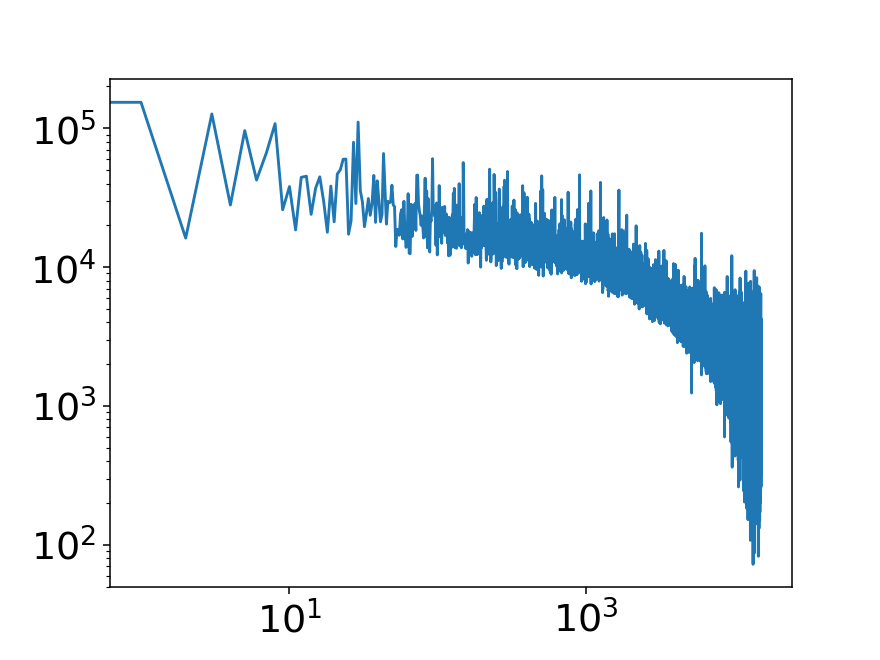

<IPython.core.display.Javascript object>


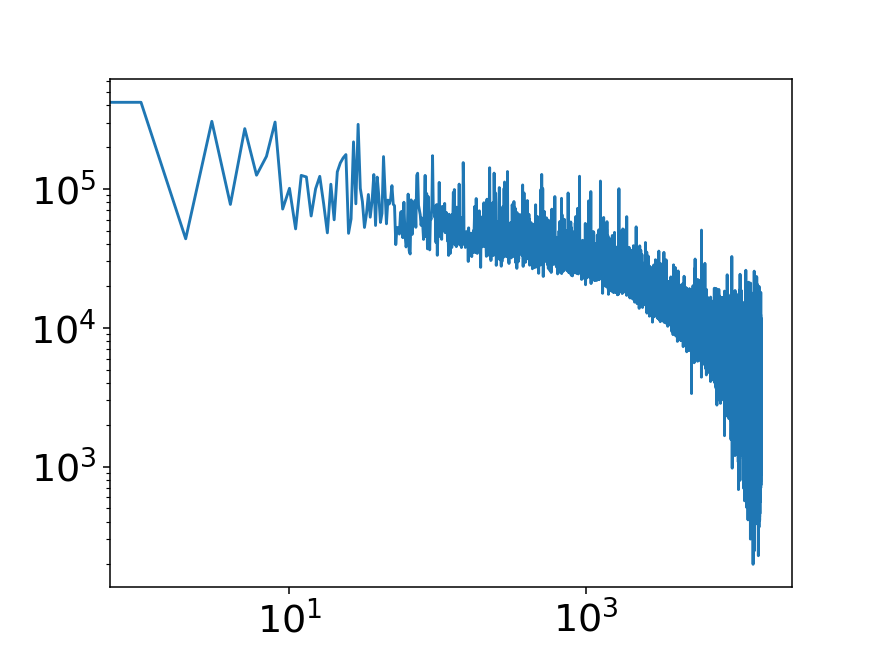

<IPython.core.display.Javascript object>


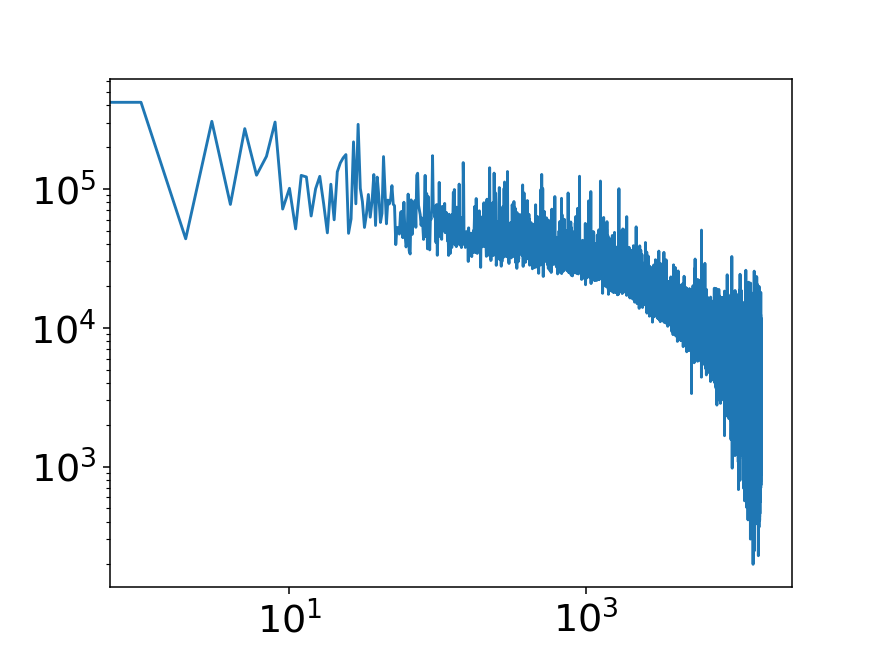

<IPython.core.display.Javascript object>


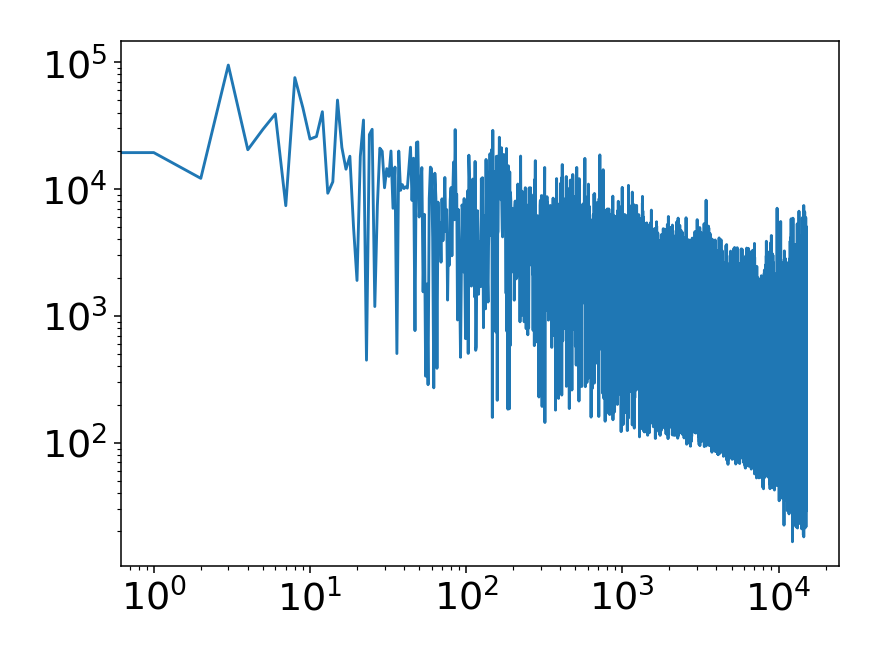

In [147]:
plt.figure()
plt.loglog(empirical_SPS)
plt.figure()
plt.loglog(empirical_SPS_abs)
plt.figure()
plt.loglog(empirical_SPS_meandef)
plt.figure()
plt.loglog(empirical_SPS_absmean)

In [9]:
#keep the [:-1] to avoid empty slice problems
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
binned_SPS = np.array([np.median(elem) for elem in np.array_split(empirical_SPS, bins)])
binned_SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
binned_SPS_err = np.array([sp.stats.sem(elem) for elem in np.array_split(empirical_SPS, bins)])
len(bins)

E:\Users\Marco1\Anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
E:\Users\Marco1\Anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


222

<IPython.core.display.Javascript object>


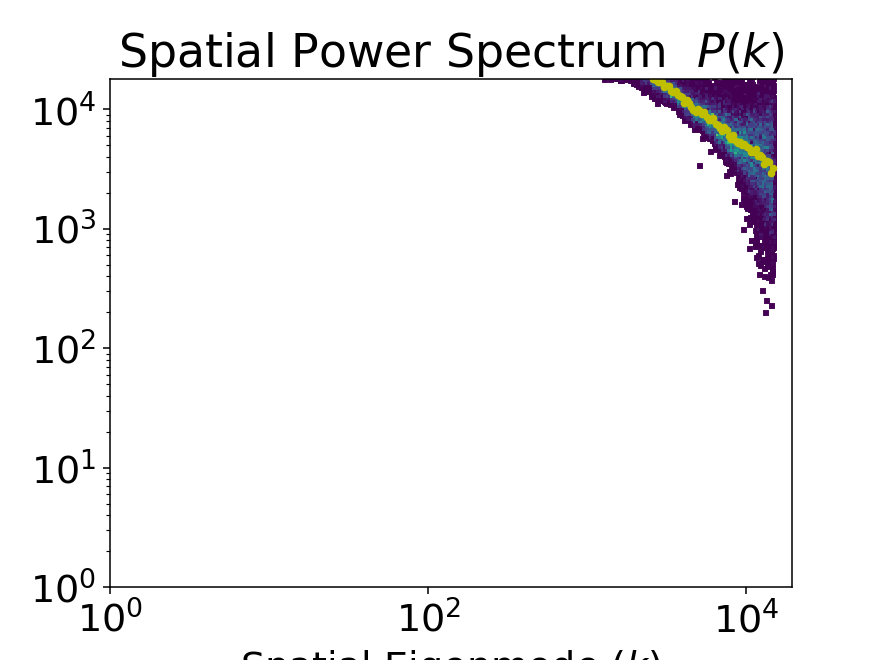

<IPython.core.display.Javascript object>


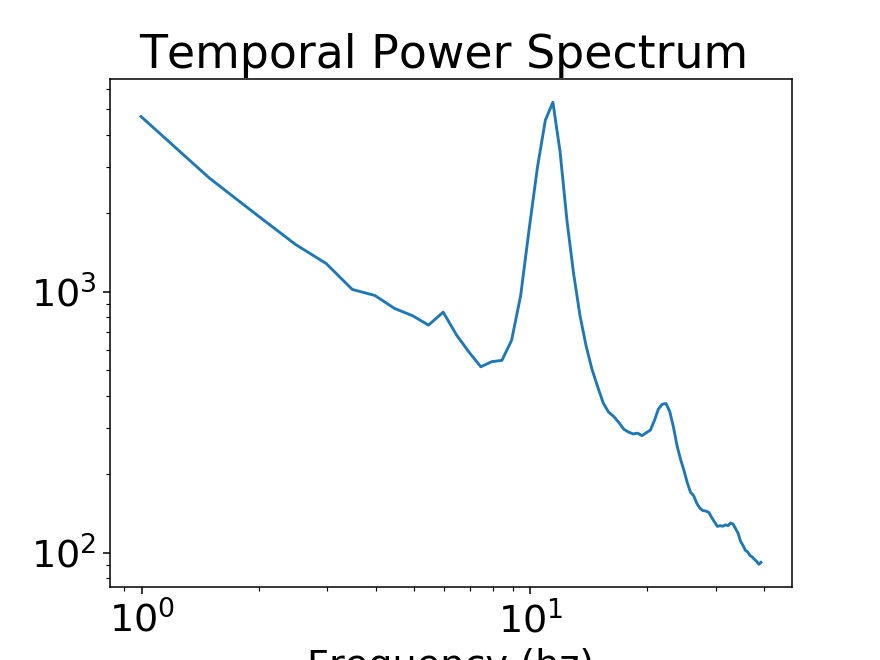

In [10]:

plt.figure()
plt.yscale('log')
plt.xscale('log')
plt.title("Spatial Power Spectrum  $P(k)$")
plt.xlabel("Spatial Eigenmode ($k$)")
#plt.errorbar(x=np.arange(len(empirical_SPS)), y=empirical_SPS, yerr=0, fmt='ks', markersize=1, zorder=1)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo',markersize=3)

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

fit_to_median=True
if fit_to_median:
    True_Spatial_Spectrum = binned_SPS
    Bins=bins
else:
    True_Spatial_Spectrum = empirical_SPS
    Bins=None
        
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

#higher gaussian TPS
higher_gaussian_TPS=100000/(100*freqs+10000)+5*np.exp((-(freqs-10)**2)/(2*0.9**2))
#lower gaussian TPS
lower_gaussian_TPS=100000/(100*freqs+10000)+3*np.exp((-(freqs-10)**2)/(2*1.2**2)) #too complex: 10*(1/(0.1*freqs+0.4)+0.7*np.exp((-(freqs-10)**2)/(2*0.9**2))+0.3*np.exp((-(freqs-22)**2)/(2*3**2)))
#even lower gaussian TPS
even_lower_gaussian_TPS=100000/(100*freqs+10000)+1.5*np.exp((-(freqs-10)**2)/(2*1.8**2))
#lowest gaussian TPS
lowest_gaussian_TPS=100000/(100*freqs+10000)+0.5*np.exp((-(freqs-10)**2)/(2*2.5**2))
#no gaussian TPS
no_gaussian_TPS=100000/(100*freqs+10000)

#new TPS, inspired by ketamine paper. suitable for loglog plotting, so multiplicative factor
new_TPS=2.5*freqs**(-1.25)+1.2*np.exp((-(freqs-10)**2)/(2*0.7**2)) + 0.06*np.exp((-(freqs-20)**2)/(2*0.7**2))
new_TPS[np.where((freqs>20) & (freqs<=40))] = 35*freqs[np.where((freqs>20) & (freqs<=40))]**(-2.17) +0.06*np.exp((-(freqs[np.where((freqs>20) & (freqs<=40))]-20)**2)/(2*0.7**2))
new_TPS[np.where(freqs>40)] = 1.17*freqs[np.where(freqs>40)]**(-1.25)

#empirical TPS from Rikkert MEG data
MEG_PS_data = sp.io.loadmat('MEG_powerspectrum.mat')
freqs = MEG_PS_data['f'][1:][:,0]
empirical_TPS = MEG_PS_data['p'].T[1:][:,0] * 10 **30#28
Min_omega=1*(2*np.pi)
Max_omega=40*(2*np.pi)
Delta_omega=0.5*(2*np.pi)
True_Temporal_Spectrum=np.array(empirical_TPS, dtype='float')#[int(len(new_TPS)*0.1):int(len(new_TPS)*0.5)]
#Max_omega=25*(2*np.pi)


fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title("Temporal Power Spectrum ")
ax.set_xlabel("Frequency (hz)")
ax.loglog(freqs, True_Temporal_Spectrum)

#change none to True_Spatial_Spectrum if want to fit to both
Args = (eigenvalues, Graph_Kernel, None, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, last_k, Bins, LSA, Visual, SaveFiles, FilePath)

In [18]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
# better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#        1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#        8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#        4.95497870e+00, 4.47579295e+00]))
plt.close('all')
aEE=115
aIE=175
aEI=190 
aII=210
dE=2.5 
dI=1 
P=0 
Q=0 
sEE=5.5 
sIE=3
sEI=3.5 
sII=100 
tE=1.2
tI=0.8
initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])
Full_Analysis(better_result['x'], *Args)

E*=0.0105, I*=0.0869: strictly stable
Best suitable steady state: 0, with Ess=0.01046 Iss=0.08694.
Dist spatial: 607.1, scale: *3.721e+04. +-2.566e+07 
Dist temporal: 0, scale: *0 +0



609.1057641803685

In [11]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000
#thesis values
result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
       1e3*8.37626732e+00, 1e3*2.74681544e+00, 1e3*3.66503548e-02, 1e3*1.00910684e+02,
       4.95497870e+00, 4.47579295e+00]))
result=dict(x=np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
 1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
 2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
 7.02896805e-01, 2.03388273e-01]))
result=dict(x=np.array([3.21305207e+02, 1.15229271e+02 ,2.70650624e+02, 1.50968021e+02,
 9.72193535e+01, 2.21122739e-01, 1.40493267e+01, 6.38403082e+00,
 2.84332179e-03, 1.20034605e-02 ,5.54375346e-02, 6.13375039e-02,
 5.39616943e-04, 2.34386738e-05]))
result=dict(x=np.array([2.68360960e+02, 1.47992427e+02, 3.40781188e+02, 1.39064758e+02,
 3.91998061e+01 ,1.49887889e+00, 2.16422343e+01, 1.48126196e+01,
 1.80443833e-02, 2.01119682e-03 ,7.65031385e-02 ,3.47241530e-02,
 1.50660781e-01 ,1.30547616e+00]))

In [42]:
initial_guess=result['x']#better_result['x']

result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='trust-constr', 
                              bounds=bnds, 
                              tol=1e-16,
                              options={#'ftol':1e-10,
                                       'xtol':1e-16,
                                       'maxiter': 2000,
                                 # 'adaptive':True,
                                  #      'maxls':50,
                                       'disp':True})

E*=0.0236, I*=0.1720: strictly stable
Best suitable steady state: 0, with Ess=0.02362 Iss=0.172.
Dist spatial: 571.9, scale: *3.17e+06. +-2.649e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1720: strictly stable
Best suitable steady state: 0, with Ess=0.02362 Iss=0.172.
Dist spatial: 571.9, scale: *3.17e+06. +-2.649e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0057, I*=0.1648: unstable
E*=0.0236, I*=0.1720: strictly stable
Best suitable steady state: 1, with Ess=0.02362 Iss=0.172.
Dist spatial: 571.9, scale: *3.17e+06. +-2.649e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1720: strictly stable
Best suitable steady state: 0, with Ess=0.02362 Iss=0.172.
Dist spatial: 571.9, scale: *3.17e+06. +-2.649e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0062, I*=0.1648: unstable
E*=0.0236, I*=0.1720: strictly stable
Best suitable steady state: 1, with Ess=0.02362 Iss=0.172.
Dist spatial: 571.9, scale: *3.17e+06. +-2.649e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1720: strictly st

Best suitable steady state: 0, with Ess=0.02364 Iss=0.172.
Dist spatial: 1.365e+04, scale: *4.016e+07. +-3.298e+06 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1722: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1722.
Dist spatial: 1.455e+04, scale: *8.759e+08. +-3.03e+07 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1722: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1722.
Dist spatial: 1.455e+04, scale: *8.759e+08. +-3.03e+07 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1722: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1722.
Dist spatial: 1.455e+04, scale: *8.759e+08. +-3.03e+07 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1722: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1722.
Dist spatial: 1.455e+04, scale: *8.759e+08. +-3.03e+07 
Dist temporal: 0, scale: *0 +0

E*=0

Best suitable steady state: 0, with Ess=0.02351 Iss=0.1723.
Dist spatial: 1.043e+04, scale: *1.745e+09. +-1.176e+08 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02351 Iss=0.1723.
Dist spatial: 1.043e+04, scale: *1.748e+09. +-1.178e+08 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02351 Iss=0.1723.
Dist spatial: 1.043e+04, scale: *1.748e+09. +-1.178e+08 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02351 Iss=0.1723.
Dist spatial: 1.043e+04, scale: *1.748e+09. +-1.178e+08 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1723: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.02351 Iss=0.1723.
Dist spatial: 1.043e+04, scale: *1.748e+09. +-1.178e+08 
Dist temporal: 0, scale: *0 +0


Best suitable steady state: 0, with Ess=0.02145 Iss=0.1739.
Dist spatial: 1.041e+04, scale: *236. +-3.861e+06 
Dist temporal: 0, scale: *0 +0

E*=0.0214, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.02145 Iss=0.1739.
Dist spatial: 1.041e+04, scale: *235.8. +-3.857e+06 
Dist temporal: 0, scale: *0 +0

E*=0.0214, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.02145 Iss=0.1739.
Dist spatial: 1.041e+04, scale: *236. +-3.861e+06 
Dist temporal: 0, scale: *0 +0

E*=0.0214, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.02145 Iss=0.1739.
Dist spatial: 1.041e+04, scale: *236. +-3.861e+06 
Dist temporal: 0, scale: *0 +0

E*=0.0214, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.02145 Iss=0.1739.
Dist spatial: 1.041e+04, scale: *236. +-3.861e+06 
Dist temporal: 0, scale: *0 +0

E*=0.0214, I*=0.1739: strictly stable
Best suitable steady state: 0, with Ess=0.02145 Iss=0.1739.
Dist spatial: 1.041e+04, scale: *

Best suitable steady state: 0, with Ess=0.02176 Iss=0.1738.
Dist spatial: 9887, scale: *23.89. +-1.915e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0218, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02176 Iss=0.1738.
Dist spatial: 9887, scale: *23.9. +-1.916e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0218, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02176 Iss=0.1738.
Dist spatial: 9887, scale: *23.9. +-1.916e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0218, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02176 Iss=0.1738.
Dist spatial: 9887, scale: *23.9. +-1.916e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0218, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02176 Iss=0.1738.
Dist spatial: 9887, scale: *23.93. +-1.916e+05 
Dist temporal: 0, scale: *0 +0

E*=0.0218, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02176 Iss=0.1738.
Dist spatial: 9887, scale: *23.9. +-1.916e+05 
Dist t

Best suitable steady state: 0, with Ess=0.02227 Iss=0.1736.
Dist spatial: 1274, scale: *17.95. +-2.256e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02227 Iss=0.1736.
Dist spatial: 1274, scale: *17.98. +-2.256e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02227 Iss=0.1736.
Dist spatial: 1274, scale: *17.95. +-2.256e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 931.5, scale: *20.93. +-2.546e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 931.5, scale: *20.93. +-2.546e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 931.5, scale: *20.93. +-2.546e+04 

Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 930.3, scale: *21.04. +-2.562e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 930, scale: *21.02. +-2.562e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 930, scale: *21.02. +-2.562e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 930.1, scale: *21.02. +-2.562e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 930.1, scale: *21.02. +-2.562e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02233 Iss=0.1735.
Dist spatial: 930, scale: *21.02. +-2.562e+04 
Di

Best suitable steady state: 0, with Ess=0.02234 Iss=0.1735.
Dist spatial: 929, scale: *21.15. +-2.583e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02234 Iss=0.1735.
Dist spatial: 929, scale: *21.15. +-2.583e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02234 Iss=0.1735.
Dist spatial: 929, scale: *21.15. +-2.583e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02234 Iss=0.1735.
Dist spatial: 929, scale: *21.15. +-2.583e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02234 Iss=0.1735.
Dist spatial: 929, scale: *21.15. +-2.583e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0223, I*=0.1735: strictly stable
Best suitable steady state: 0, with Ess=0.02234 Iss=0.1735.
Dist spatial: 929, scale: *21.15. +-2.583e+04 
Dist tem

Best suitable steady state: 0, with Ess=0.02238 Iss=0.1736.
Dist spatial: 919.1, scale: *22.24. +-2.713e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02238 Iss=0.1736.
Dist spatial: 919.1, scale: *22.24. +-2.713e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02238 Iss=0.1736.
Dist spatial: 919.1, scale: *22.24. +-2.713e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02238 Iss=0.1736.
Dist spatial: 919.1, scale: *22.24. +-2.713e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02238 Iss=0.1736.
Dist spatial: 919.1, scale: *22.24. +-2.713e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02238 Iss=0.1736.
Dist spatial: 919.1, scale: *22.24. +-2.713e+

Best suitable steady state: 0, with Ess=0.02245 Iss=0.1736.
Dist spatial: 905.7, scale: *23.68. +-2.902e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02245 Iss=0.1736.
Dist spatial: 905.7, scale: *23.68. +-2.902e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02245 Iss=0.1736.
Dist spatial: 905.7, scale: *23.68. +-2.902e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02245 Iss=0.1736.
Dist spatial: 905.7, scale: *23.68. +-2.902e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02245 Iss=0.1736.
Dist spatial: 905.7, scale: *23.68. +-2.902e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0224, I*=0.1736: strictly stable
Best suitable steady state: 0, with Ess=0.02245 Iss=0.1736.
Dist spatial: 905.7, scale: *23.68. +-2.902e+

Best suitable steady state: 0, with Ess=0.02258 Iss=0.1737.
Dist spatial: 882.2, scale: *26.77. +-3.309e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0226, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02258 Iss=0.1737.
Dist spatial: 882.2, scale: *26.77. +-3.309e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0226, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02258 Iss=0.1737.
Dist spatial: 882.2, scale: *26.77. +-3.309e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0226, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02258 Iss=0.1737.
Dist spatial: 882.2, scale: *26.77. +-3.309e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0226, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02258 Iss=0.1737.
Dist spatial: 882.2, scale: *26.77. +-3.309e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0226, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02258 Iss=0.1737.
Dist spatial: 882.2, scale: *26.77. +-3.309e+

Best suitable steady state: 0, with Ess=0.02266 Iss=0.1737.
Dist spatial: 866.7, scale: *28.59. +-3.556e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0227, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02266 Iss=0.1737.
Dist spatial: 866.7, scale: *28.59. +-3.556e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0227, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02266 Iss=0.1737.
Dist spatial: 866.7, scale: *28.59. +-3.556e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0227, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02266 Iss=0.1737.
Dist spatial: 866.7, scale: *28.59. +-3.556e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0227, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02266 Iss=0.1737.
Dist spatial: 866.7, scale: *28.59. +-3.556e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0227, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02266 Iss=0.1737.
Dist spatial: 866.7, scale: *28.59. +-3.556e+

Best suitable steady state: 0, with Ess=0.02314 Iss=0.1738.
Dist spatial: 813.4, scale: *42.12. +-5.402e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02314 Iss=0.1738.
Dist spatial: 813.4, scale: *42.12. +-5.402e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02314 Iss=0.1738.
Dist spatial: 813.4, scale: *42.12. +-5.402e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02314 Iss=0.1738.
Dist spatial: 813.4, scale: *42.12. +-5.402e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02314 Iss=0.1738.
Dist spatial: 813.4, scale: *42.12. +-5.402e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02314 Iss=0.1738.
Dist spatial: 813.4, scale: *42.12. +-5.402e+

Best suitable steady state: 0, with Ess=0.02312 Iss=0.1738.
Dist spatial: 811, scale: *42.69. +-5.444e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02312 Iss=0.1738.
Dist spatial: 811, scale: *42.69. +-5.444e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02312 Iss=0.1738.
Dist spatial: 811, scale: *42.69. +-5.444e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02312 Iss=0.1738.
Dist spatial: 811, scale: *42.69. +-5.444e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02312 Iss=0.1738.
Dist spatial: 811, scale: *42.69. +-5.444e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0231, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02312 Iss=0.1738.
Dist spatial: 811, scale: *42.69. +-5.444e+04 
Dist tem

Best suitable steady state: 0, with Ess=0.02317 Iss=0.1738.
Dist spatial: 797.1, scale: *44.07. +-5.637e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02317 Iss=0.1738.
Dist spatial: 797.1, scale: *44.07. +-5.637e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02317 Iss=0.1738.
Dist spatial: 797.1, scale: *44.07. +-5.637e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02317 Iss=0.1738.
Dist spatial: 797.1, scale: *44.07. +-5.637e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02317 Iss=0.1738.
Dist spatial: 797.1, scale: *44.07. +-5.637e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02317 Iss=0.1738.
Dist spatial: 797.1, scale: *44.07. +-5.637e+

Best suitable steady state: 0, with Ess=0.02318 Iss=0.1737.
Dist spatial: 792.6, scale: *44.02. +-5.643e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02318 Iss=0.1737.
Dist spatial: 792.6, scale: *44.02. +-5.643e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02318 Iss=0.1737.
Dist spatial: 792.6, scale: *44.02. +-5.643e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02318 Iss=0.1737.
Dist spatial: 792.6, scale: *44.02. +-5.643e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02318 Iss=0.1737.
Dist spatial: 792.6, scale: *44.02. +-5.643e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02318 Iss=0.1737.
Dist spatial: 792.6, scale: *44.02. +-5.643e+

Best suitable steady state: 0, with Ess=0.0232 Iss=0.1737.
Dist spatial: 790.9, scale: *44.62. +-5.723e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.0232 Iss=0.1737.
Dist spatial: 790.9, scale: *44.62. +-5.723e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.0232 Iss=0.1737.
Dist spatial: 790.9, scale: *44.62. +-5.723e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.0232 Iss=0.1737.
Dist spatial: 790.9, scale: *44.62. +-5.723e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.0232 Iss=0.1737.
Dist spatial: 790.9, scale: *44.62. +-5.723e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.0232 Iss=0.1737.
Dist spatial: 790.9, scale: *44.69. +-5.723e+04 
Di

Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.3, scale: *44.44. +-5.697e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.3, scale: *44.44. +-5.697e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.3, scale: *44.44. +-5.697e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.3, scale: *44.44. +-5.697e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.3, scale: *44.51. +-5.697e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.3, scale: *44.44. +-5.697e+

Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.2, scale: *44.46. +-5.699e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.2, scale: *44.46. +-5.699e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.2, scale: *44.53. +-5.699e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.2, scale: *44.46. +-5.699e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.1, scale: *44.49. +-5.703e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1737: strictly stable
Best suitable steady state: 0, with Ess=0.02319 Iss=0.1737.
Dist spatial: 790.1, scale: *44.49. +-5.703e+

Best suitable steady state: 0, with Ess=0.02321 Iss=0.1738.
Dist spatial: 789.6, scale: *45.12. +-5.779e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02321 Iss=0.1738.
Dist spatial: 789.6, scale: *45.05. +-5.779e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02323 Iss=0.1738.
Dist spatial: 788.5, scale: *46. +-5.908e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02323 Iss=0.1738.
Dist spatial: 788.5, scale: *46. +-5.908e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02323 Iss=0.1738.
Dist spatial: 788.5, scale: *46. +-5.908e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0232, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02323 Iss=0.1738.
Dist spatial: 788.5, scale: *46. +-5.908e+04 
Dist tem

Best suitable steady state: 0, with Ess=0.02328 Iss=0.1738.
Dist spatial: 785.5, scale: *47.83. +-6.154e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02328 Iss=0.1738.
Dist spatial: 785.5, scale: *47.83. +-6.154e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02328 Iss=0.1738.
Dist spatial: 785.5, scale: *47.83. +-6.154e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02328 Iss=0.1738.
Dist spatial: 785.5, scale: *47.83. +-6.154e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02328 Iss=0.1738.
Dist spatial: 785.5, scale: *47.83. +-6.154e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02328 Iss=0.1738.
Dist spatial: 785.5, scale: *47.83. +-6.154e+

Best suitable steady state: 0, with Ess=0.02334 Iss=0.1738.
Dist spatial: 783, scale: *50.06. +-6.456e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02334 Iss=0.1738.
Dist spatial: 783, scale: *50.06. +-6.456e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02334 Iss=0.1738.
Dist spatial: 783, scale: *50.06. +-6.456e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02334 Iss=0.1738.
Dist spatial: 783, scale: *50.06. +-6.456e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02334 Iss=0.1738.
Dist spatial: 783, scale: *50.06. +-6.456e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0233, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02334 Iss=0.1738.
Dist spatial: 783, scale: *50.06. +-6.456e+04 
Dist tem

Best suitable steady state: 1, with Ess=0.02344 Iss=0.1738.
Dist spatial: 778.1, scale: *54.56. +-7.064e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0063, I*=0.1664: unstable
E*=0.0234, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02344 Iss=0.1738.
Dist spatial: 778.1, scale: *54.56. +-7.064e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0063, I*=0.1664: unstable
E*=0.0234, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02344 Iss=0.1738.
Dist spatial: 778.1, scale: *54.56. +-7.064e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0063, I*=0.1664: unstable
E*=0.0234, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02344 Iss=0.1738.
Dist spatial: 778.1, scale: *54.56. +-7.064e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0063, I*=0.1664: unstable
E*=0.0234, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02344 Iss=0.1738.
Dist spatial: 778.1, scale: *54.56. +-7.064e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0063, I*=0.166

Best suitable steady state: 1, with Ess=0.02353 Iss=0.1738.
Dist spatial: 776, scale: *58.74. +-7.616e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02353 Iss=0.1738.
Dist spatial: 776, scale: *58.65. +-7.616e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.03. +-7.668e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.03. +-7.668e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.03. +-7.668e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.03. +-7.668e+04 


Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.21. +-7.693e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 776.1, scale: *59.75. +-7.763e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0086, I*=0.1679: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02355 Iss=0.1738.
Dist spatial: 776.1, scale: *59.75. +-7.763e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 776.1, scale: *59.75. +-7.763e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 776.1, scale: *59.75. +-7.763e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.16. +-7.686e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.16. +-7.686e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.16. +-7.686e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.16. +-7.686e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0084, I*=0.1677: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.16. +-7.686e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0084, I*=0.1677: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0085, I*=0.1677: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0079, I*=0.1675: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.25. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.25. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.25. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.25. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.25. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.15. +-7.685e+

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 776.3, scale: *59.37. +-7.716e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 776.3, scale: *59.37. +-7.716e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 776.3, scale: *59.47. +-7.716e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 776.3, scale: *59.37. +-7.716e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 776, scale: *59.33. +-7.71e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 776, scale: *59.33. +-7.71e+04 
Di

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.29. +-7.692e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.2. +-7.692e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.18. +-7.689e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.18. +-7.689e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.8, scale: *59.18. +-7.689e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0083, I*=0.1676: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 7

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.21. +-7.693e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.23. +-7.696e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.23. +-7.696e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.23. +-7.696e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.23. +-7.696e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.23. +-7.696e+

E*=0.0084, I*=0.1677: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.37. +-7.714e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.37. +-7.714e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0084, I*=0.1677: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.37. +-7.714e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.37. +-7.714e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.37. +-7.714e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best 

Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.48. +-7.73e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.48. +-7.73e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.48. +-7.73e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.48. +-7.73e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.48. +-7.73e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02354 Iss=0.1738.
Dist spatial: 775.7, scale: *59.48. +-7.73e+04 
Di

Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.66. +-7.754e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.66. +-7.754e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.66. +-7.754e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0073, I*=0.1671: unstable
E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.66. +-7.754e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.66. +-7.754e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0235, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.86. +-7.781e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.86. +-7.781e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.86. +-7.781e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.86. +-7.781e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.86. +-7.781e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.86. +-7.781e+

Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.94. +-7.792e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.94. +-7.792e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.94. +-7.792e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.94. +-7.792e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.94. +-7.792e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.6, scale: *59.94. +-7.792e+

Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.98. +-7.797e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.98. +-7.797e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.98. +-7.797e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.98. +-7.797e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.98. +-7.797e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02355 Iss=0.1738.
Dist spatial: 775.5, scale: *59.98. +-7.797e+

Best suitable steady state: 1, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.26. +-7.835e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.26. +-7.835e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0083, I*=0.1677: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.26. +-7.835e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.26. +-7.835e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.26. +-7.835e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.48. +-7.863e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1677: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.48. +-7.863e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.48. +-7.863e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.48. +-7.863e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.48. +-7.863e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.45. +-7.859e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.45. +-7.859e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.45. +-7.859e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.45. +-7.859e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.45. +-7.859e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.45. +-7.859e+

Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.44. +-7.858e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.44. +-7.858e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.44. +-7.858e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.44. +-7.858e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1677: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.4, scale: *60.44. +-7.858e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.52. +-7.87e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.52. +-7.87e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.52. +-7.87e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.52. +-7.87e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3, scale: *60.52. +-7.87e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.3

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0066, I*=0.1668: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0084, I*=0.1678: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.0

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.88e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.88e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.88e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.88e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.88e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, sca

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0081, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0095, I*=0.1685: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Di

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0077, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist sp

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0089, I*=0.1681: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0079, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1677: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0081, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0087, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.0

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0078, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitabl

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0074, I*=0.1673: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+

Best suitable steady state: 0, with Ess=0.02356 Iss=0.1738.
Dist spatial: 775.8, scale: *60.5. +-7.867e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.5, scale: *60.56. +-7.876e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.5, scale: *60.56. +-7.876e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0087, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.5, scale: *60.56. +-7.876e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.5, scale: *60.56. +-7.876e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 7

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.6. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0089, I*=0.1681: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.881e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with E

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0081, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0095, I*=0.1685: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0079, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitabl

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.7. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 7

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.7. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0087, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 7

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.7. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0066, I*=0.1669: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 7

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.7. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0070, I*=0.1670: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.7. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 7

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0004, I*=0.1591: strictly stable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist sp

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0075, I*=0.1673: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0079, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0074, I*=0.1673: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0087, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.71. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0085, I*=0.1678: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0066, I*=0.1669: unstable
E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 2, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0


E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist s

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0076, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0065, I*=0.1668: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0085, I*=0.1678: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0076, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0075, I*=0.1673: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0087, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0067, I*=0.1669: unstable
E*=0.0078, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 2, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0077, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0084, I*=0.1678: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0081, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0081, I*=0.1677: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.0

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0089, I*=0.1681: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0070, I*=0.1670: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0068, I*=0.1670: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0081, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitabl

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0065, I*=0.1668: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0079, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.0

Best suitable steady state: 2, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0077, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0068, I*=0.1669: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0089, I*=0.1681: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0079, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0069, I*=0.1670: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0077, I*=0.1675: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitabl

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0089, I*=0.1681: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.882e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist sp

Best suitable steady state: 2, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0082, I*=0.1677: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitabl

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0088, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0078, I*=0.1674: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 

Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0080, I*=0.1676: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0087, I*=0.1680: unstable
E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 1, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist spatial: 775.3, scale: *60.61. +-7.883e+04 
Dist temporal: 0, scale: *0 +0

E*=0.0236, I*=0.1738: strictly stable
Best suitable steady state: 0, with Ess=0.02357 Iss=0.1738.
Dist sp

KeyboardInterrupt: 

In [32]:
#log norm1 **2 + area =   571.9
print(result['x'])

[2.68360960e+02 1.47992427e+02 3.40781188e+02 1.39064758e+02
 3.91998061e+01 1.49887889e+00 2.16422343e+01 1.48126196e+01
 1.80443833e-02 2.01119682e-03 7.65031385e-02 3.47241530e-02
 1.50660781e-01 1.30547616e+00]


In [195]:
#log norm1 **2 + area =  570.9
print(result['x'])

[3.21305207e+02 1.15229271e+02 2.70650624e+02 1.50968021e+02
 9.72193535e+01 2.21122739e-01 1.40493267e+01 6.38403082e+00
 2.84332179e-03 1.20034605e-02 5.54375346e-02 6.13375039e-02
 5.39616943e-04 2.34386738e-05]


In [179]:
#log norm1 **2 + area =  572.7 (TNC) (see 570 with nelme)
print(result['x'])

[3.22451578e+02 1.15073431e+02 2.69248996e+02 1.50533135e+02
 9.55822710e+01 2.18179446e-01 1.40582563e+01 6.32583702e+00
 2.82810786e-03 1.13218133e-02 5.62222898e-02 6.11171348e-02
 5.35437129e-04 2.43341374e-05]


In [134]:
#log norm1 dist 13.92 (352 area)
print(result['x'])

[3.22451375e+02 1.15073390e+02 2.69248937e+02 1.50533175e+02
 9.55820078e+01 2.18169985e-01 1.40582533e+01 6.32581599e+00
 2.74446417e-03 1.13807689e-02 5.62246812e-02 6.09131988e-02
 7.58526730e-06 2.96701876e-07]


In [130]:
#log norm1 dist 14.49
print(result['x'])

[4.23915417e+02 7.91000144e+01 2.79819671e+02 1.19223776e+02
 1.04894934e+02 3.75392169e-01 1.04568707e+01 7.81878983e+00
 2.72943068e-03 1.14612063e-02 6.20938495e-02 7.77630783e-02
 6.79570554e-06 3.06182606e-07]


In [123]:
#area between curves in log (not loglog) space as objective function. 2norm in log space for scaling (26/01/20)
#1336sp 39te (linear sum, interim best)
#792.2sp 31.7te (product)(excellent for spatial, bad for temporal)
#778sp 30te
#289.5 areas between curv dist, 15.28 log norm1 dist 
print(result['x'])

[5.08661178e+02 8.56564882e+01 2.86499756e+02 1.24370119e+02
 1.67980687e+02 3.75904834e-01 1.06324841e+01 8.40942399e+00
 2.73768830e-03 1.14661574e-02 1.12808657e+01 1.14239037e-01
 5.79890898e-06 7.71465777e-07]


In [28]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

#best previous spectrum
new_initial_guess=result['x']

#spectrum (thesis)
#old_initial_guess=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00])

#new_initial_guess=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]['x']

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds]):#, hello=this_temporal_distance):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
        #self.hello = hello
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        New_Dist=Full_Analysis(x, eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)
        
        success = New_Dist<1e6
        
        #if t and success and New_Dist<self.hello:
        #    self.hello=New_Dist
        #    new_initial_guess=np.copy(x)
        
        return t and success
    
    
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    #Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
     
    result = sp.optimize.minimize(fun,x0,args=Args, method='L-BFGS-B',# bounds=Bounds,
                                #tol=1e-16,
                                options={'maxiter':2000, 
                                        # 'ftol': 1e-10,
                                        # 'maxls': 100,
                                         'disp':True})
    print(result)
    
    return result


# better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=1, stepsize=10,
#                                   minimizer_kwargs=dict(method=custom_min),
#                                   accept_test=MyBounds(), disp=True)

Init=np.stack((new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess))


better_result = sp.optimize.differential_evolution(Full_Analysis, bounds=bnds, 
                                                 args=Args, tol=1e-10, disp=True, init=Init,
                                                 maxiter=25000, polish=True, workers=-1) #recombination=0.1,
                                                 #updating='deferred',
                                                #mutation=0)


differential_evolution step 3164: f(x)= 572.915
differential_evolution step 3165: f(x)= 572.915
differential_evolution step 3166: f(x)= 572.915
differential_evolution step 3167: f(x)= 572.915
differential_evolution step 3168: f(x)= 572.915
differential_evolution step 3169: f(x)= 572.915
differential_evolution step 3170: f(x)= 572.915
differential_evolution step 3171: f(x)= 572.915
differential_evolution step 3172: f(x)= 572.915
differential_evolution step 3173: f(x)= 572.915
differential_evolution step 3174: f(x)= 572.915
differential_evolution step 3175: f(x)= 572.915
differential_evolution step 3176: f(x)= 572.915
differential_evolution step 3177: f(x)= 572.915
differential_evolution step 3178: f(x)= 572.915
differential_evolution step 3179: f(x)= 572.915
differential_evolution step 3180: f(x)= 572.915
differential_evolution step 3181: f(x)= 572.915
differential_evolution step 3182: f(x)= 572.915
differential_evolution step 3183: f(x)= 572.915
differential_evolution step 3184: f(x)= 

KeyboardInterrupt: 

[[0.00650314 0.02362116]
 [0.16481002 0.17200357]]


<IPython.core.display.Javascript object>


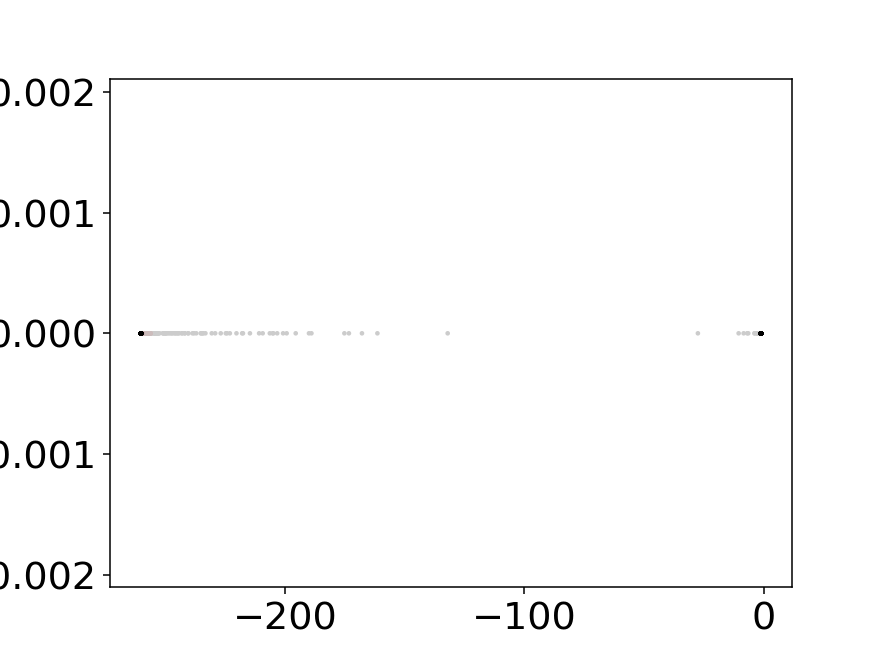

E*=0.0236, I*=0.1720: strictly stable


<IPython.core.display.Javascript object>


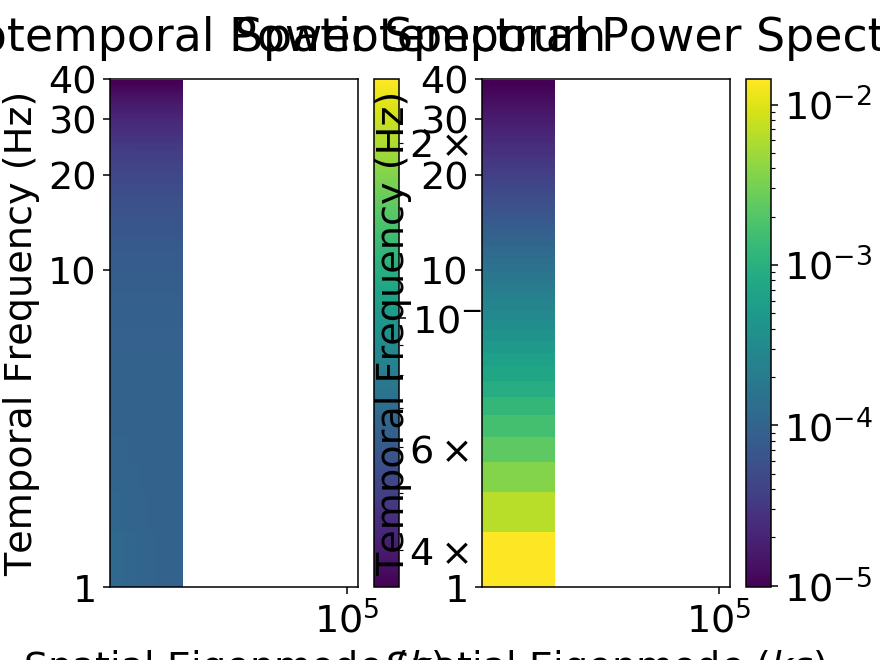

<IPython.core.display.Javascript object>


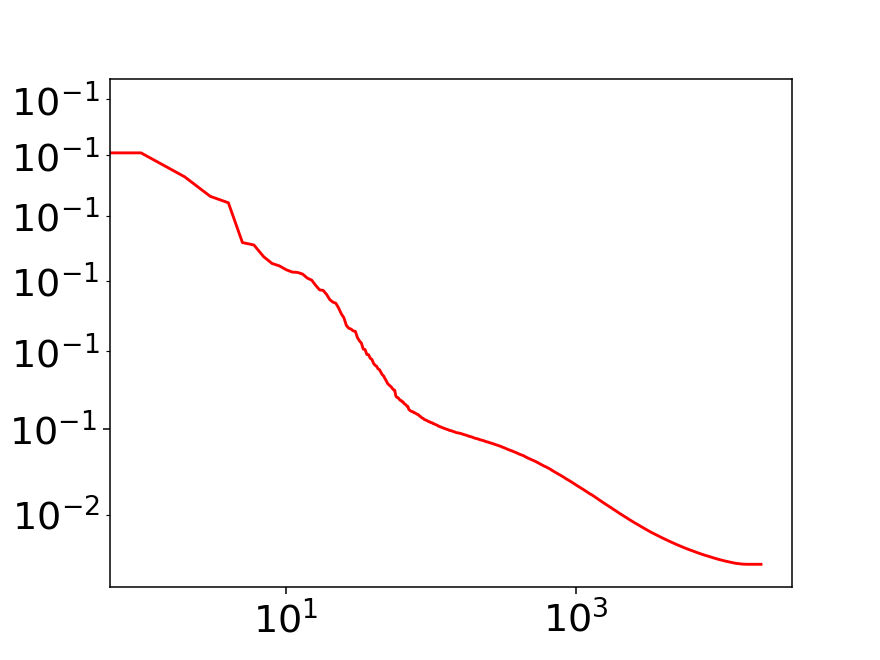

In [14]:
#re-analyze result of minimization procedure

#thesis parameters
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#better_result=np.load('decent_spatiotemporal_spectrum.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy', allow_pickle=True)[()]

#IMPORTANT: if using spectra above, run the line below, since they were not done in metres
#better_result['x'][8:12]/=1000

#better_result=np.load('decent_spatiotemporal_spectrum_first_new_realistic_metres.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_tps.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_sps.npy', allow_pickle=True)[()]
#better_result=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]

#better_result = np.load('stps_empirical_loglog_median_fitting.npy', allow_pickle=True)[()]

better_result = result

SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
print(SStates)       

SSnr=1
sigma_noise=1

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13], Visual=True)    


E_Spectrum, I_Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=True)

Spectrum_spatial_only = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=True, Visual=True)


#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, plot
#init_notebook_mode(connected=True)

#data = [go.Surface(
#                                x=np.arange(1,len(eigenvalues)+1),
#                                y=freqs,
#                                z=Spectrum.T
#                                )
#                ]

#layout = go.Layout(scene=dict(
#    xaxis=dict(
#        type='log',
#        autorange=True
#    ),
#    yaxis=dict(
#        type='log',
#        autorange=True
#    ),
#    zaxis=dict(
#        type='log',
#        autorange=True
#    ))
#)
#fig_ly = go.Figure(data=data, layout=layout)
#plot(fig_ly,filename='E:\whatever.html')



<IPython.core.display.Javascript object>


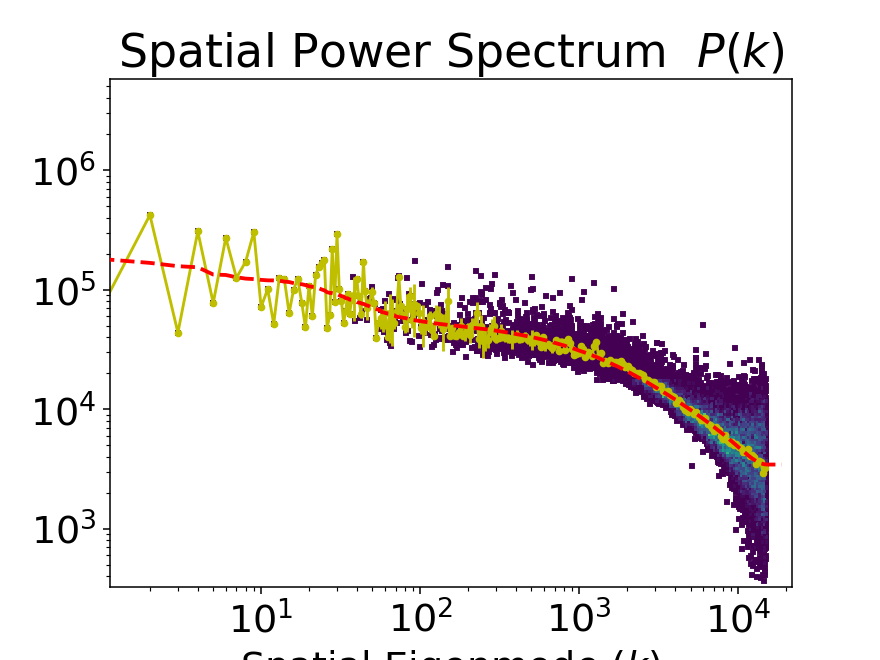

spatial scale factors: [3169706.53585609 -264909.76039231]
spatial distance: 332.07077739385807
Ks_2sampResult(statistic=0.5699922595736577, pvalue=1.96352832822327e-62)
Ks_2sampResult(statistic=0.09865470852017937, pvalue=0.22824420313737323)


<IPython.core.display.Javascript object>


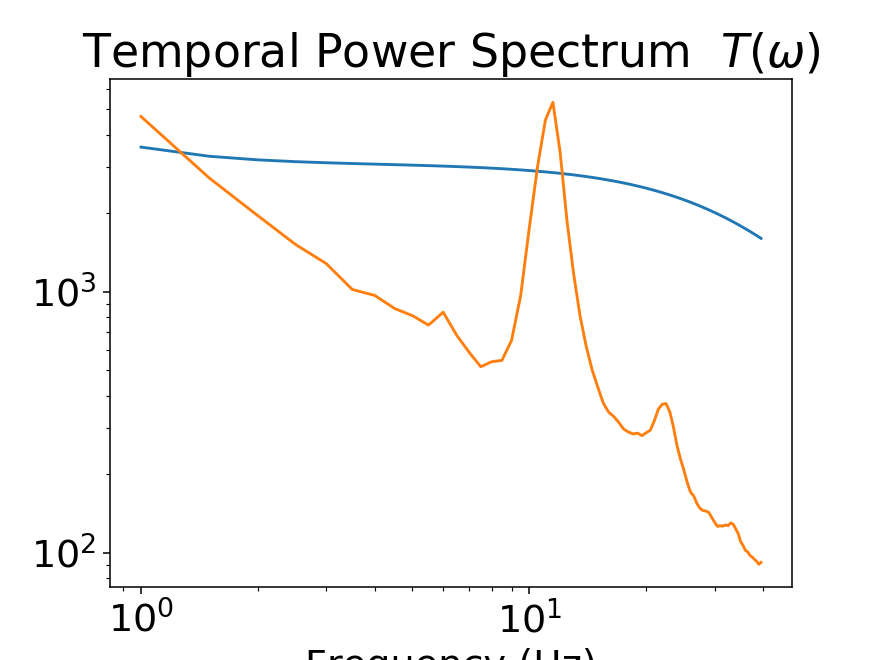

temporal scale factor: [ 1.27115322e+02 -2.06874613e+01  9.25953918e-01 -1.82820569e+03]
temporal distance: 204.69390722164832
[[1.0 0.5894681347511265]
 [0.5894681347511265 1.0]]
[[1.0 0.7664693967812503]
 [0.7664693967812503 1.0]]
Ks_2sampResult(statistic=0.8846153846153846, pvalue=4.091985472142154e-32)
[2.68360960e+02 1.47992427e+02 3.40781188e+02 1.39064758e+02
 3.91998061e+01 1.49887889e+00 2.16422343e+01 1.48126196e+01
 1.80443833e-02 2.01119682e-03 7.65031385e-02 3.47241530e-02
 1.50660781e-01 1.30547616e+00]


E:\Users\Marco1\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [15]:
import seaborn as sns
from analysis import find_scaling, NF_to_empirical
Gk_E=Spectrum_spatial_only[:,0,0] #Delta_omega*np.sum(Spectrum,axis=0)/np.pi
Gk_I=Spectrum_spatial_only[:,1,1]
Gw_E=2*np.sum(E_Spectrum,axis=1)
Gw_I=2*np.sum(I_Spectrum,axis=1)
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")

if not fit_to_median:
    E_spatial_spectrum = Gk_E
    I_spatial_spectrum = Gk_I
    SPS_points = np.arange(first_k,last_k)
else:
    E_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_E[first_k:last_k], bins)])
    I_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_I[first_k:last_k], bins)])
    SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])

    
# a_matrix_spatial = np.vstack((E_spatial_spectrum,
#                               I_spatial_spectrum,
#                               E_spatial_spectrum*I_spatial_spectrum,
#                               np.ones_like(True_Spatial_Spectrum))).T

# scale_params_spatial = np.linalg.lstsq(a_matrix_spatial, True_Spatial_Spectrum)[0]    
scale_params_spatial = sp.optimize.fmin(find_scaling, x0=[1e4,1e6], args=(E_spatial_spectrum,I_spatial_spectrum,True_Spatial_Spectrum), disp=0)

# n_spatial = len(True_Spatial_Spectrum)    
# a_spatial = (n_spatial*np.dot(E_spatial_spectrum,True_Spatial_Spectrum)-np.sum(True_Spatial_Spectrum)*np.sum(E_spatial_spectrum))/(n_spatial*np.dot(E_spatial_spectrum,E_spatial_spectrum)-np.sum(E_spatial_spectrum)**2)
# b_spatial = (np.sum(True_Spatial_Spectrum)-a_spatial*np.sum(E_spatial_spectrum))/n_spatial
# scale_params_spatial = np.array([a_spatial,b_spatial])

current_spatial_spectrum = NF_to_empirical(scale_params_spatial,
                                           E_spatial_spectrum,
                                           I_spatial_spectrum)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values                    
current_spatial_spectrum[current_spatial_spectrum<=0] = 1e-10

data_1=np.vstack((SPS_points, np.log10(True_Spatial_Spectrum))).T
data_2=np.vstack((SPS_points, np.log10(current_spatial_spectrum))).T

dist_spatial = sm.area_between_two_curves(data_1,data_2)

print("spatial scale factors: {}".format(scale_params_spatial))
print("spatial distance: {}".format(dist_spatial))

ax.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
ax.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

ax.loglog(np.arange(len(eigenvalues)),  NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), zorder=3,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3)

print(sp.stats.ks_2samp(empirical_SPS,  current_spatial_spectrum))
print(sp.stats.ks_2samp(True_Spatial_Spectrum, current_spatial_spectrum))
      
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Temporal Power Spectrum  $T(\omega)$")
ax.set_xlabel("Frequency (Hz)")

freqs=np.arange(Min_omega,Max_omega,Delta_omega)

a_matrix_temporal = np.vstack((Gw_E,
                               Gw_I,
                               Gw_E*Gw_I,
                               np.ones_like(True_Temporal_Spectrum))).T

scale_params_temporal = np.linalg.lstsq(a_matrix_temporal, True_Temporal_Spectrum)[0]
#scale_params_temporal = sp.optimize.fmin(find_scaling, x0=[1,0], args=(Gw_E,Gw_I,True_Temporal_Spectrum), disp=0)

current_temporal_spectrum = NF_to_empirical(scale_params_temporal,
                                            Gw_E, Gw_I)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values
#current_temporal_spectrum[current_temporal_spectrum<=0] = 1e-10

data_3=np.vstack((freqs,np.log10(True_Temporal_Spectrum))).T
data_4=np.vstack((freqs,np.log10(current_temporal_spectrum))).T

dist_temporal = sm.area_between_two_curves(data_3,data_4)
           
print("temporal scale factor: {}".format(scale_params_temporal))
print("temporal distance: {}".format(dist_temporal))

print(np.ma.corrcoef(True_Temporal_Spectrum, current_temporal_spectrum))
print(np.ma.corrcoef(True_Spatial_Spectrum, current_spatial_spectrum))


print(sp.stats.ks_2samp(True_Temporal_Spectrum, current_temporal_spectrum))

ax.loglog(freqs/(2*np.pi),
            current_temporal_spectrum)
ax.loglog(freqs/(2*np.pi), 
            True_Temporal_Spectrum)

#np.save('decent_spatiotemporal_spectrum.npy', better_result)
print(better_result['x'])


In [ ]:
#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]['x']-better_result['x']
#current best (loglog space fitting)
[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]
#logspace excellent s2.16 t0.86 (kstat pval 0.21 0.68)
better_result['x'] [ 1.60298254e+03,  1.84931805e+02,  2.99551387e+03,  2.80138120e+02,
  9.29297308e+01,  1.22714483e+00,  7.24240357e+00,  3.71750330e-01,
  4.34632128e-04,  2.05916610e-05,  6.11898211e-04, -3.38503489e+10,
  6.93229886e+00,  1.51916190e-01]
#np.save('stps_empirical_first_loglog_median_fitting.npy', better_result)
[6.32352428e+02, 7.93766496e+01, 3.47535746e+02, 1.07039076e+02,
       1.56586247e+02, 4.22226636e+00, 1.54479298e+01, 2.49662094e+01,
       4.31042051e-02, 2.44534241e-03, 4.77988694e-02, 5.17697376e-02,
       1.37486268e-01, 6.30906093e-01])

better_result['x']=[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]

In [13]:
#np.save('stps_empirical_loglog_median_fitting.npy', better_result)

In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

<IPython.core.display.Javascript object>


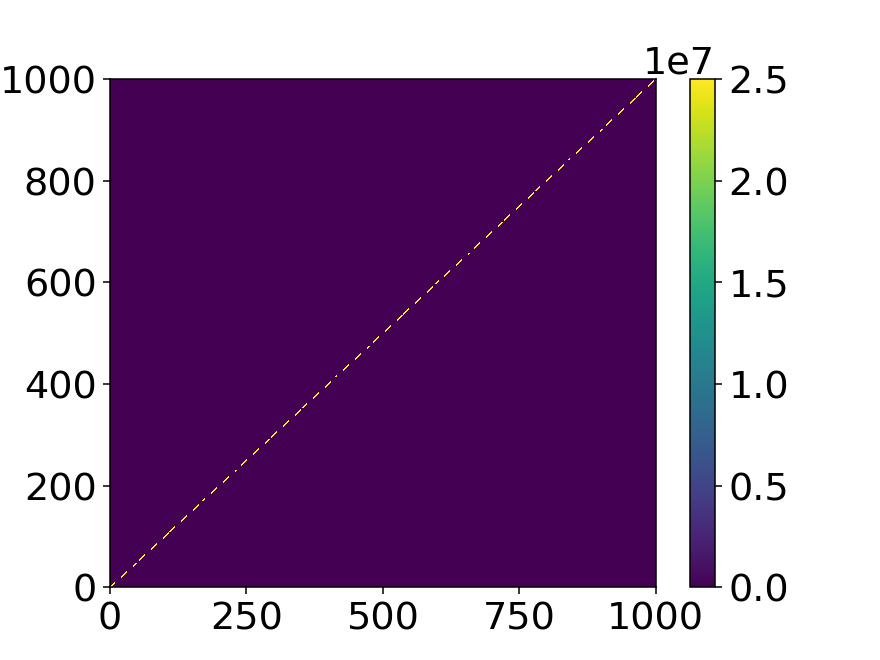

<IPython.core.display.Javascript object>


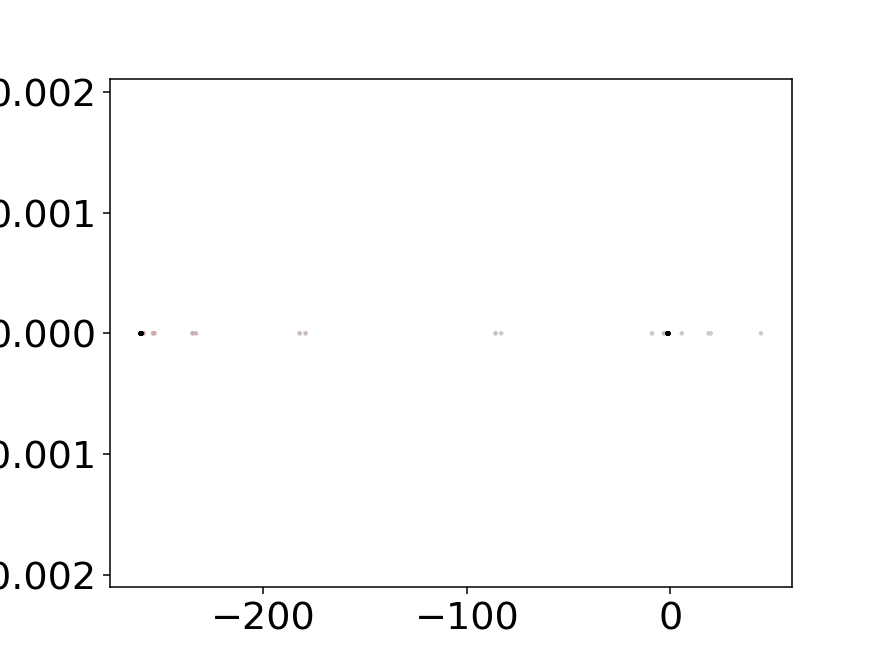

E*=0.0063, I*=0.1648: unstable


<IPython.core.display.Javascript object>


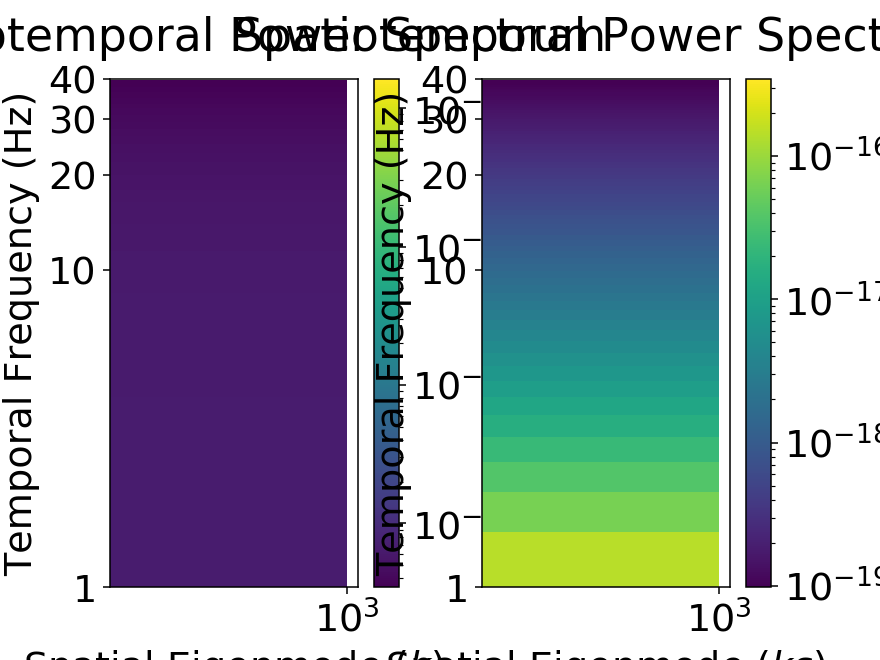

<IPython.core.display.Javascript object>


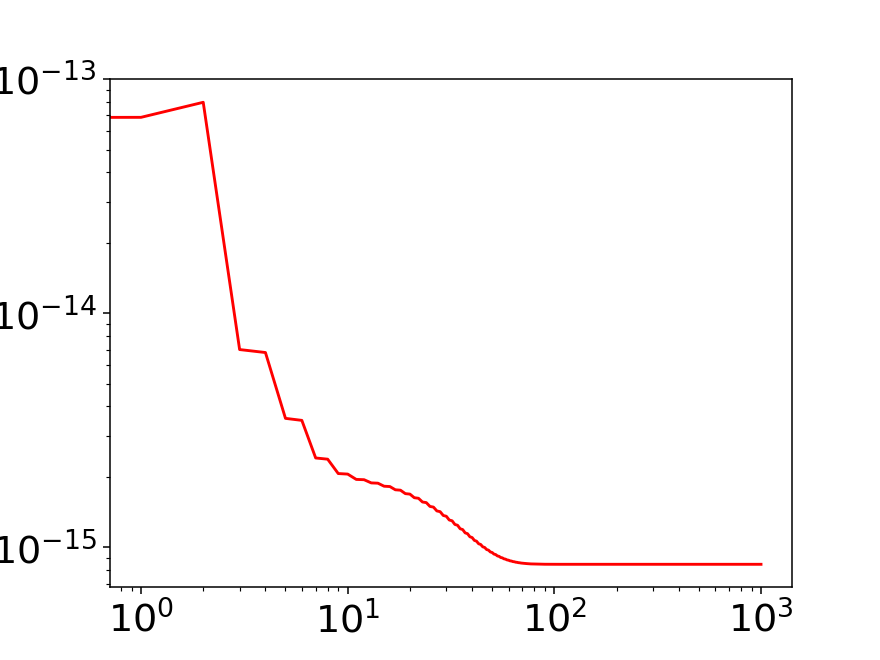

<IPython.core.display.Javascript object>


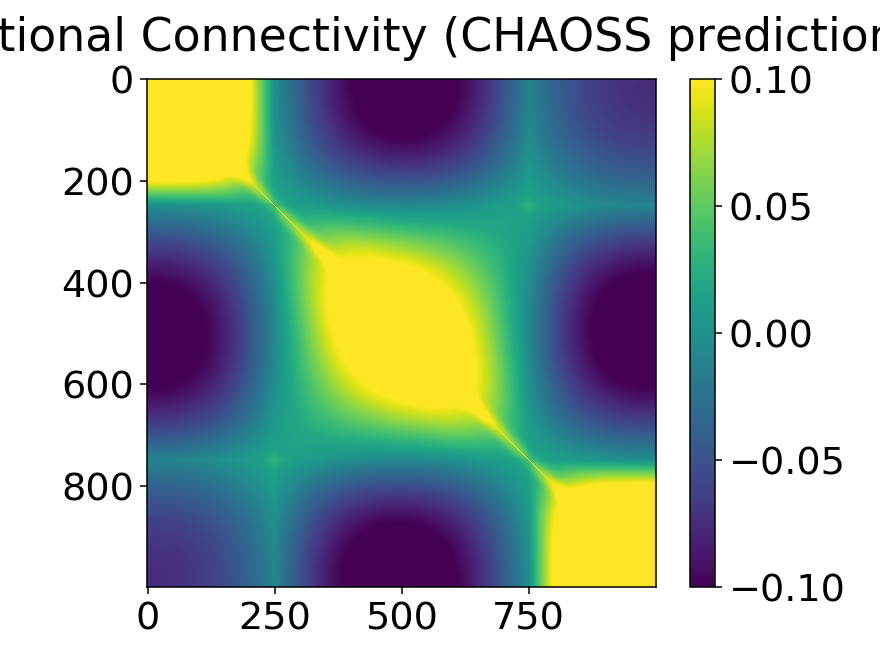

<IPython.core.display.Javascript object>


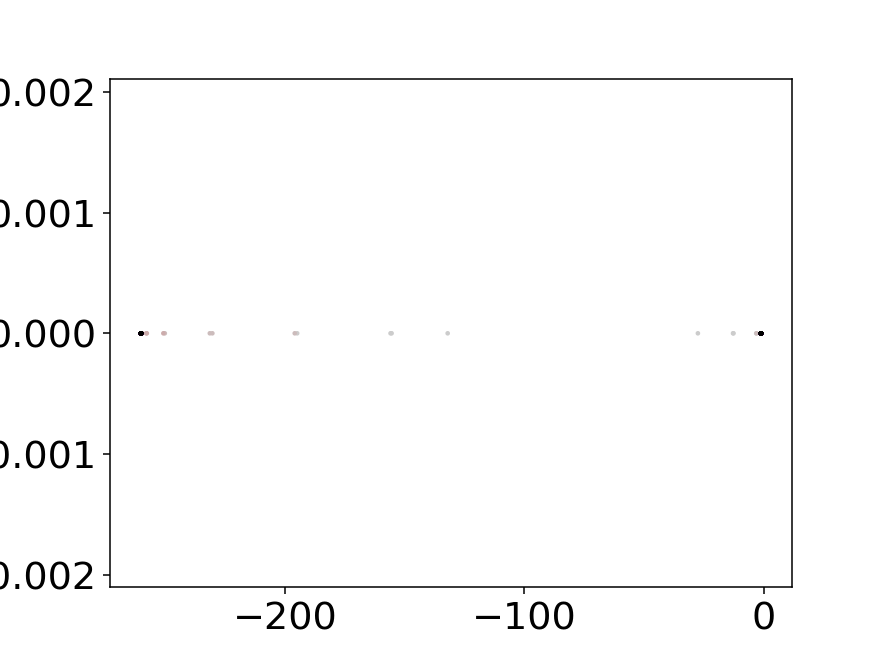

E*=0.0236, I*=0.1720: strictly stable


<IPython.core.display.Javascript object>


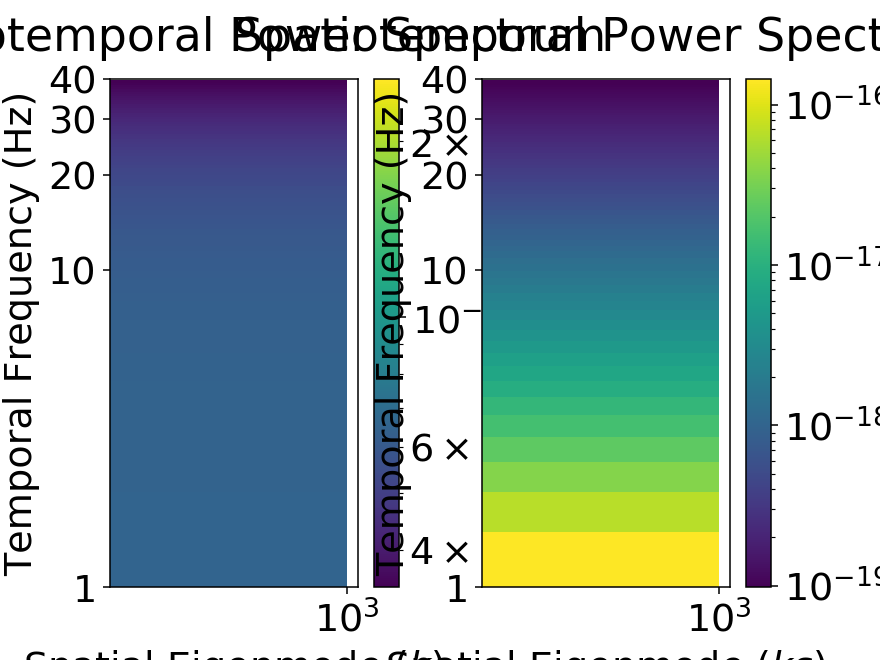

<IPython.core.display.Javascript object>


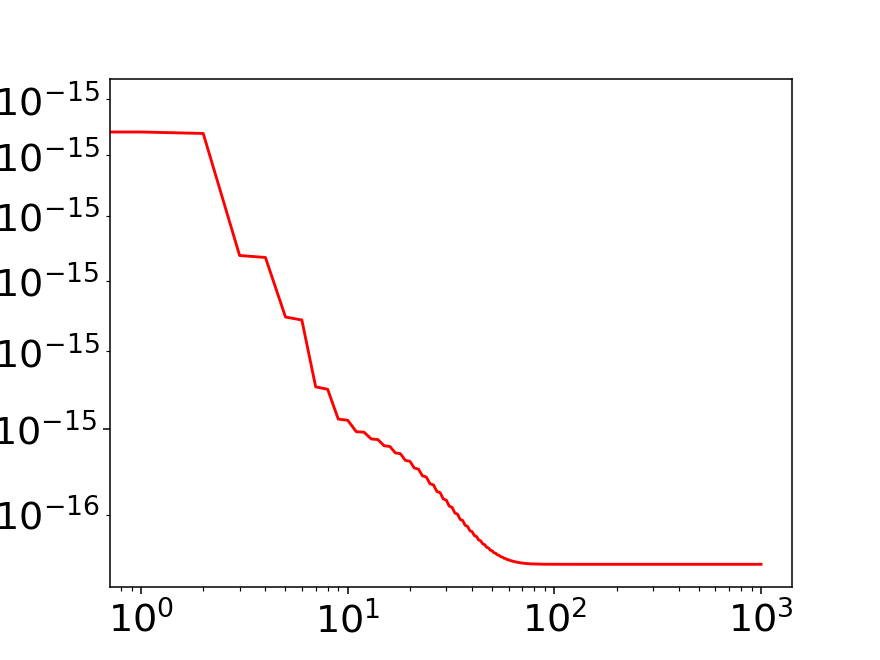

<IPython.core.display.Javascript object>


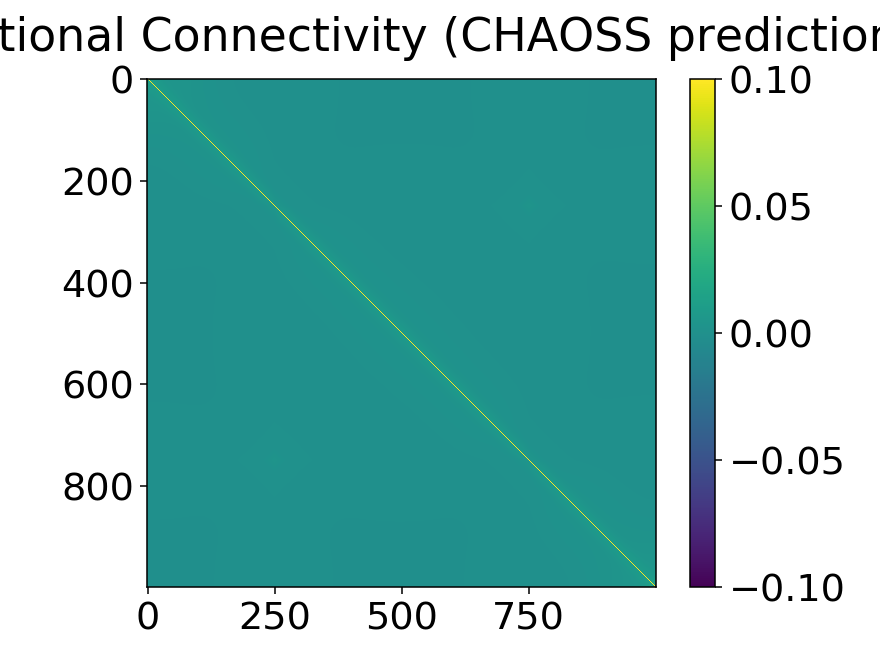

In [28]:
#1D predictions
#set up 1D-specific simulation parameters and WCM propagators
one_dim=False
syn=1
#if making plot from connectome minimization, need to change this value to the number of connectome nodes
gridsize=1000#len(eigenvalues)
h=0.0002
#Min_omega=5*(2*np.pi)
#Max_omega=50*(2*np.pi)
#Delta_omega=0.1*(2*np.pi)

Graph_Kernel='Gaussian'
one_dim_eigenvalues, one_dim_eigenvectors = one_dim_Laplacian_eigenvalues(gridsize, h, syn, vecs=True)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#thesis result
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=1
tE=better_result['x'][12]
tI=better_result['x'][13]
snE=0.0000001
#snE=0.0001
snI=snE

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    allGI = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI, Visual=True) 

        #allG[ss,:,:] = 
        allG[ss,:,:], allGI[ss,:,:] =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI, 
                                                  Min_omega, Max_omega, Delta_omega,          
                                                   Spatial_Spectrum_Only=False, Visual=True)
        
        sspectrum =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI,         
                                                   Spatial_Spectrum_Only=True, Visual=True)
        

        
        Func_Conn_prediction = Functional_Connectivity(one_dim_eigenvectors, sspectrum[:,0,0], one_dim=True, Visual=True)
        

        

<IPython.core.display.Javascript object>


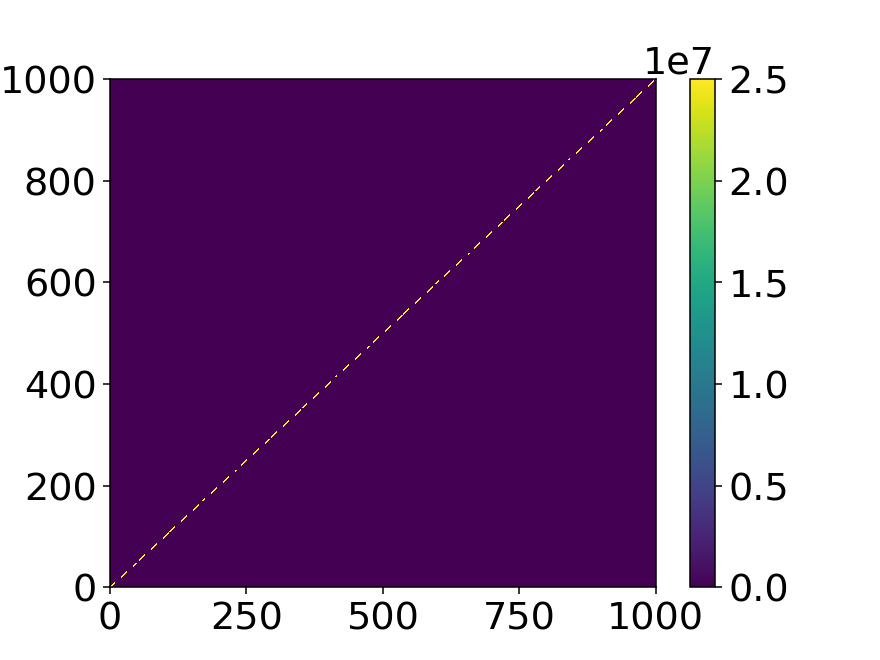

<IPython.core.display.Javascript object>


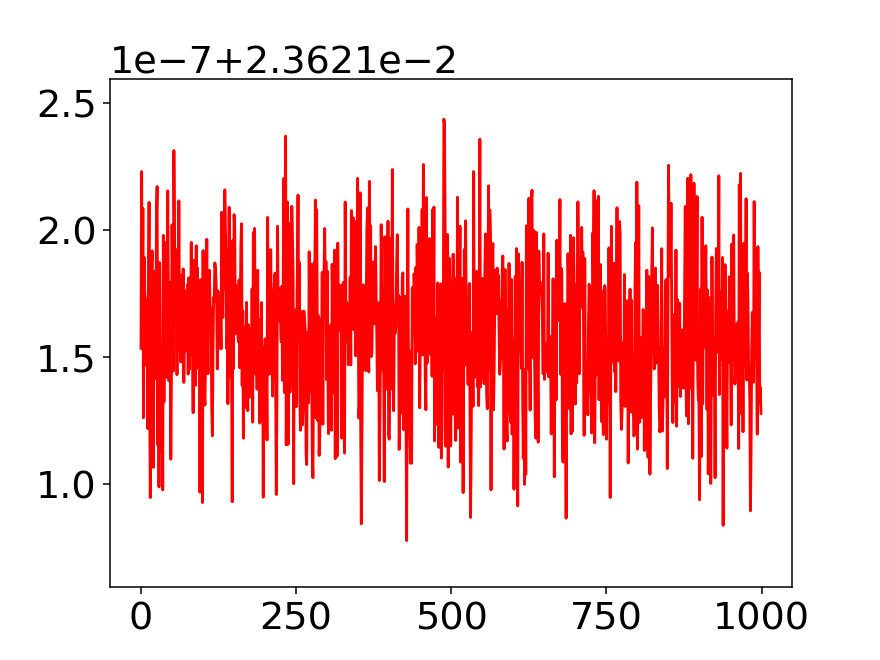

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
1718

29180
29190
29200
29210
29220
29230
29240
29250
29260
29270
29280
29290
29300
29310
29320
29330
29340
29350
29360
29370
29380
29390
29400
29410
29420
29430
29440
29450
29460
29470
29480
29490
29500
29510
29520
29530
29540
29550
29560
29570
29580
29590
29600
29610
29620
29630
29640
29650
29660
29670
29680
29690
29700
29710
29720
29730
29740
29750
29760
29770
29780
29790
29800
29810
29820
29830
29840
29850
29860
29870
29880
29890
29900
29910
29920
29930
29940
29950
29960
29970
29980
29990
30000
30010
30020
30030
30040
30050
30060
30070
30080
30090
30100
30110
30120
30130
30140
30150
30160
30170
30180
30190
30200
30210
30220
30230
30240
30250
30260
30270
30280
30290
30300
30310
30320
30330
30340
30350
30360
30370
30380
30390
30400
30410
30420
30430
30440
30450
30460
30470
30480
30490
30500
30510
30520
30530
30540
30550
30560
30570
30580
30590
30600
30610
30620
30630
30640
30650
30660
30670
30680
30690
30700
30710
30720
30730
30740
30750
30760
30770
30780
30790
30800
30810
30820
30830
3084

42850
42860
42870
42880
42890
42900
42910
42920
42930
42940
42950
42960
42970
42980
42990
43000
43010
43020
43030
43040
43050
43060
43070
43080
43090
43100
43110
43120
43130
43140
43150
43160
43170
43180
43190
43200
43210
43220
43230
43240
43250
43260
43270
43280
43290
43300
43310
43320
43330
43340
43350
43360
43370
43380
43390
43400
43410
43420
43430
43440
43450
43460
43470
43480
43490
43500
43510
43520
43530
43540
43550
43560
43570
43580
43590
43600
43610
43620
43630
43640
43650
43660
43670
43680
43690
43700
43710
43720
43730
43740
43750
43760
43770
43780
43790
43800
43810
43820
43830
43840
43850
43860
43870
43880
43890
43900
43910
43920
43930
43940
43950
43960
43970
43980
43990
44000
44010
44020
44030
44040
44050
44060
44070
44080
44090
44100
44110
44120
44130
44140
44150
44160
44170
44180
44190
44200
44210
44220
44230
44240
44250
44260
44270
44280
44290
44300
44310
44320
44330
44340
44350
44360
44370
44380
44390
44400
44410
44420
44430
44440
44450
44460
44470
44480
44490
44500
4451

56520
56530
56540
56550
56560
56570
56580
56590
56600
56610
56620
56630
56640
56650
56660
56670
56680
56690
56700
56710
56720
56730
56740
56750
56760
56770
56780
56790
56800
56810
56820
56830
56840
56850
56860
56870
56880
56890
56900
56910
56920
56930
56940
56950
56960
56970
56980
56990
57000
57010
57020
57030
57040
57050
57060
57070
57080
57090
57100
57110
57120
57130
57140
57150
57160
57170
57180
57190
57200
57210
57220
57230
57240
57250
57260
57270
57280
57290
57300
57310
57320
57330
57340
57350
57360
57370
57380
57390
57400
57410
57420
57430
57440
57450
57460
57470
57480
57490
57500
57510
57520
57530
57540
57550
57560
57570
57580
57590
57600
57610
57620
57630
57640
57650
57660
57670
57680
57690
57700
57710
57720
57730
57740
57750
57760
57770
57780
57790
57800
57810
57820
57830
57840
57850
57860
57870
57880
57890
57900
57910
57920
57930
57940
57950
57960
57970
57980
57990
58000
58010
58020
58030
58040
58050
58060
58070
58080
58090
58100
58110
58120
58130
58140
58150
58160
58170
5818

70180
70190
70200
70210
70220
70230
70240
70250
70260
70270
70280
70290
70300
70310
70320
70330
70340
70350
70360
70370
70380
70390
70400
70410
70420
70430
70440
70450
70460
70470
70480
70490
70500
70510
70520
70530
70540
70550
70560
70570
70580
70590
70600
70610
70620
70630
70640
70650
70660
70670
70680
70690
70700
70710
70720
70730
70740
70750
70760
70770
70780
70790
70800
70810
70820
70830
70840
70850
70860
70870
70880
70890
70900
70910
70920
70930
70940
70950
70960
70970
70980
70990
71000
71010
71020
71030
71040
71050
71060
71070
71080
71090
71100
71110
71120
71130
71140
71150
71160
71170
71180
71190
71200
71210
71220
71230
71240
71250
71260
71270
71280
71290
71300
71310
71320
71330
71340
71350
71360
71370
71380
71390
71400
71410
71420
71430
71440
71450
71460
71470
71480
71490
71500
71510
71520
71530
71540
71550
71560
71570
71580
71590
71600
71610
71620
71630
71640
71650
71660
71670
71680
71690
71700
71710
71720
71730
71740
71750
71760
71770
71780
71790
71800
71810
71820
71830
7184

83850
83860
83870
83880
83890
83900
83910
83920
83930
83940
83950
83960
83970
83980
83990
84000
84010
84020
84030
84040
84050
84060
84070
84080
84090
84100
84110
84120
84130
84140
84150
84160
84170
84180
84190
84200
84210
84220
84230
84240
84250
84260
84270
84280
84290
84300
84310
84320
84330
84340
84350
84360
84370
84380
84390
84400
84410
84420
84430
84440
84450
84460
84470
84480
84490
84500
84510
84520
84530
84540
84550
84560
84570
84580
84590
84600
84610
84620
84630
84640
84650
84660
84670
84680
84690
84700
84710
84720
84730
84740
84750
84760
84770
84780
84790
84800
84810
84820
84830
84840
84850
84860
84870
84880
84890
84900
84910
84920
84930
84940
84950
84960
84970
84980
84990
85000
85010
85020
85030
85040
85050
85060
85070
85080
85090
85100
85110
85120
85130
85140
85150
85160
85170
85180
85190
85200
85210
85220
85230
85240
85250
85260
85270
85280
85290
85300
85310
85320
85330
85340
85350
85360
85370
85380
85390
85400
85410
85420
85430
85440
85450
85460
85470
85480
85490
85500
8551

97520
97530
97540
97550
97560
97570
97580
97590
97600
97610
97620
97630
97640
97650
97660
97670
97680
97690
97700
97710
97720
97730
97740
97750
97760
97770
97780
97790
97800
97810
97820
97830
97840
97850
97860
97870
97880
97890
97900
97910
97920
97930
97940
97950
97960
97970
97980
97990
98000
98010
98020
98030
98040
98050
98060
98070
98080
98090
98100
98110
98120
98130
98140
98150
98160
98170
98180
98190
98200
98210
98220
98230
98240
98250
98260
98270
98280
98290
98300
98310
98320
98330
98340
98350
98360
98370
98380
98390
98400
98410
98420
98430
98440
98450
98460
98470
98480
98490
98500
98510
98520
98530
98540
98550
98560
98570
98580
98590
98600
98610
98620
98630
98640
98650
98660
98670
98680
98690
98700
98710
98720
98730
98740
98750
98760
98770
98780
98790
98800
98810
98820
98830
98840
98850
98860
98870
98880
98890
98900
98910
98920
98930
98940
98950
98960
98970
98980
98990
99000
99010
99020
99030
99040
99050
99060
99070
99080
99090
99100
99110
99120
99130
99140
99150
99160
99170
9918

In [34]:
#1D grid simulation (nonlinear wilson-cowan)
#thesis values
#Time=100
#Delta_t=0.01

#more recent param set values
#Time=3
#Delta_t=0.0001

#duration and timestep (empirical loglog median fitting)
Time=10
Delta_t=0.00005

#duration and timestep (empirical spatial only linear scaling)
Time=10
Delta_t=0.0001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

nrSS=1
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    


E_total = Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                                  
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         Visual=True, SaveActivity=False, Filepath=' ')   


<IPython.core.display.Javascript object>


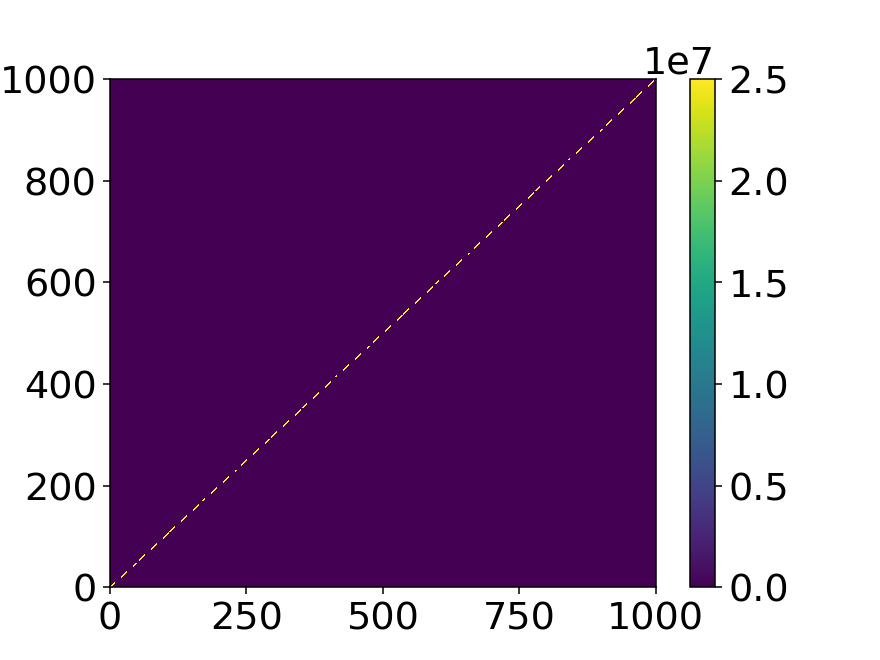

Simulation SPS obtained.
Simulation TPS obtained.
All simulation activity measures completed.
Obtaining analytic predictions...


<IPython.core.display.Javascript object>


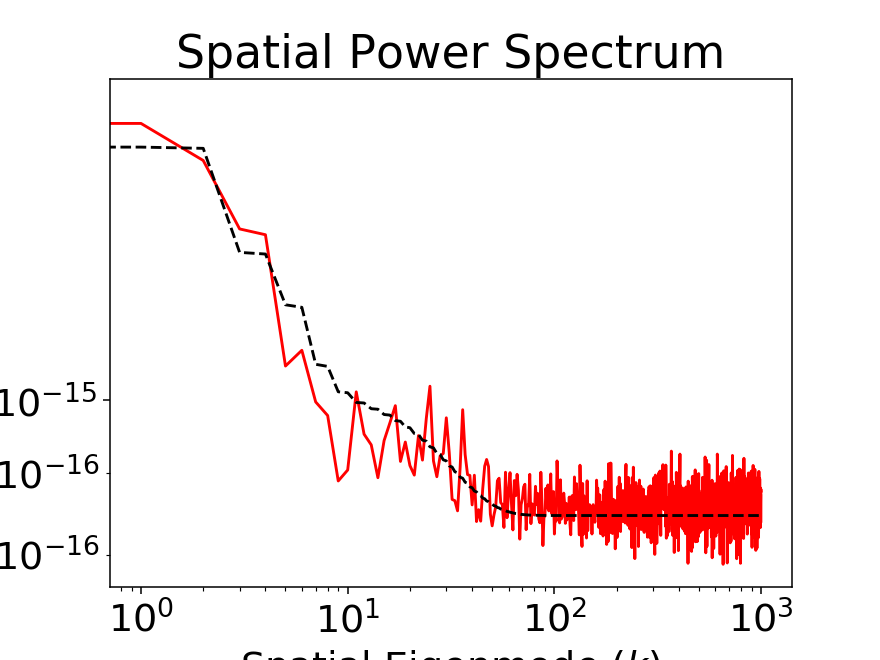

<IPython.core.display.Javascript object>


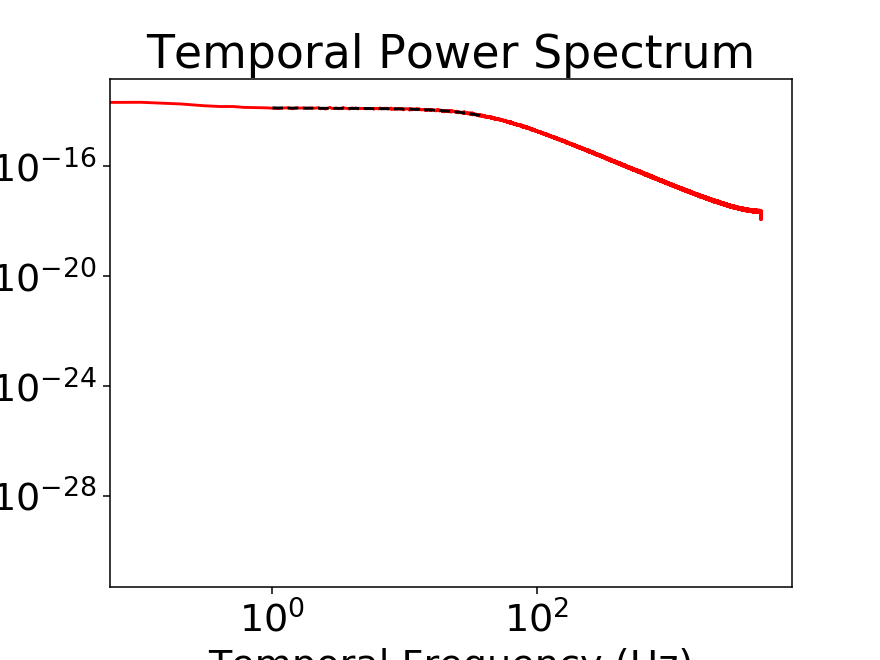

<IPython.core.display.Javascript object>


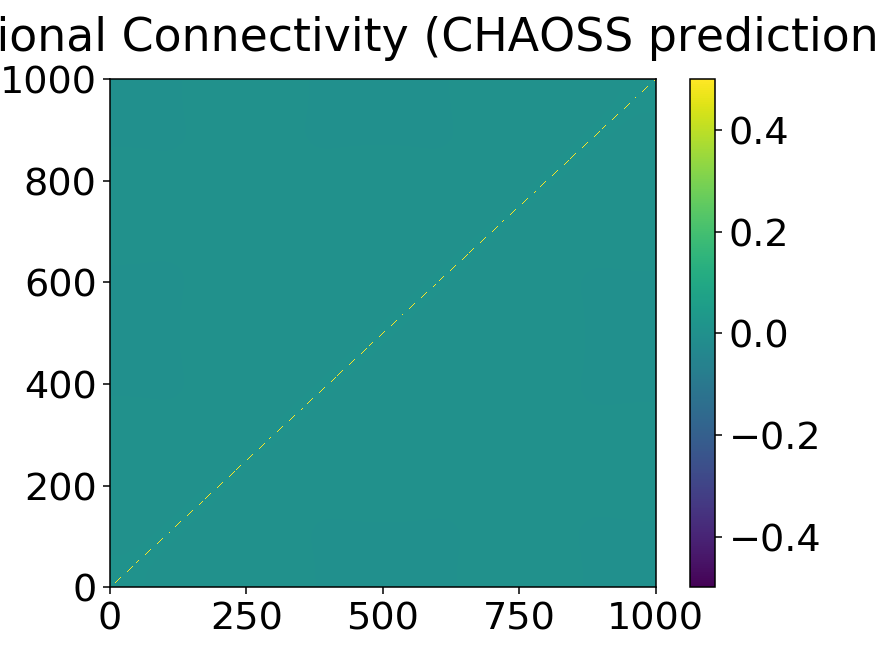

<IPython.core.display.Javascript object>


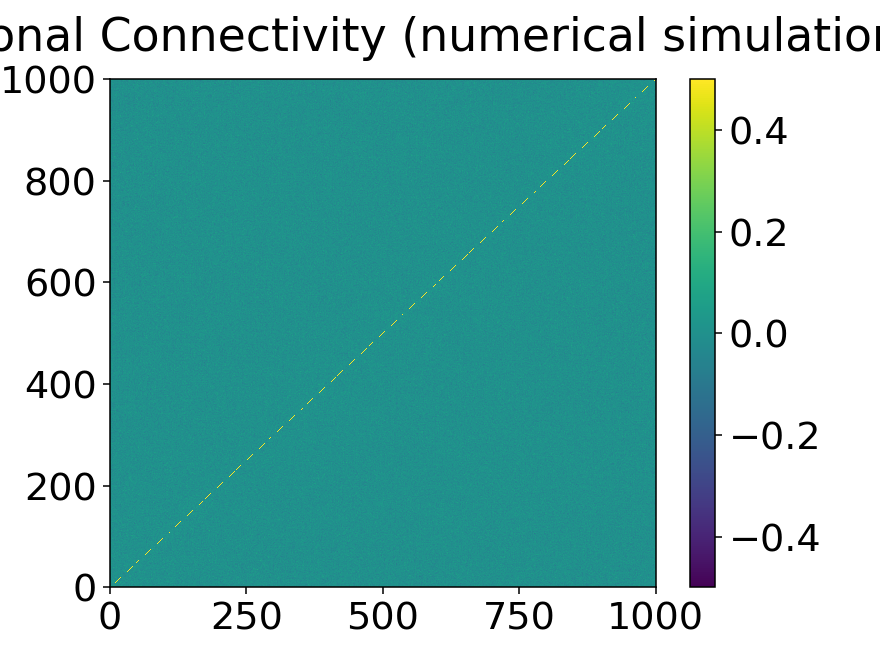

In [36]:
#activity analysis and comparison with prediction
#thesis values
#Max_omega=50
#Delta_omega=0.1

#Min_omega=1*(2*np.pi)
#Max_omega=100*(2*np.pi)

PS, TPS, FC = Activity_Analysis(Ess, Iss, Delta_t, 
                            aEE, aIE, aEI, aII,
                            sEE, sIE, sEI, sII, D,
                            dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                             
                            beta=False, E_total=E_total,                                                      
                            prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,                        
                            one_dim=True, syn=syn, gridsize=gridsize, h=h,                           
                            Visual=True, Save_Results=False, Filepath=' ')


In [11]:
#Human connectome simulation (linearized wilson-cowan: perturbation about steady state)
#thesis time and timestep values
#Time=100
#Delta_t=0.01
#more recent work
Time=2
Delta_t=0.0001
#final (empirical)
Time=7.5
Delta_t=0.00005

nrSS=1
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  
SPS_sims=[]
TPS_sims=[]
for sims in range(1):
    Beta_E_total = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=False, eigvals=eigenvalues, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 

    PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')
    
    SPS_sims.append(PS_full)
    TPS_sims.append(TPS_full)
    del Beta_E_total


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
1717

29170
29180
29190
29200
29210
29220
29230
29240
29250
29260
29270
29280
29290
29300
29310
29320
29330
29340
29350
29360
29370
29380
29390
29400
29410
29420
29430
29440
29450
29460
29470
29480
29490
29500
29510
29520
29530
29540
29550
29560
29570
29580
29590
29600
29610
29620
29630
29640
29650
29660
29670
29680
29690
29700
29710
29720
29730
29740
29750
29760
29770
29780
29790
29800
29810
29820
29830
29840
29850
29860
29870
29880
29890
29900
29910
29920
29930
29940
29950
29960
29970
29980
29990
30000
30010
30020
30030
30040
30050
30060
30070
30080
30090
30100
30110
30120
30130
30140
30150
30160
30170
30180
30190
30200
30210
30220
30230
30240
30250
30260
30270
30280
30290
30300
30310
30320
30330
30340
30350
30360
30370
30380
30390
30400
30410
30420
30430
30440
30450
30460
30470
30480
30490
30500
30510
30520
30530
30540
30550
30560
30570
30580
30590
30600
30610
30620
30630
30640
30650
30660
30670
30680
30690
30700
30710
30720
30730
30740
30750
30760
30770
30780
30790
30800
30810
30820
3083

42830
42840
42850
42860
42870
42880
42890
42900
42910
42920
42930
42940
42950
42960
42970
42980
42990
43000
43010
43020
43030
43040
43050
43060
43070
43080
43090
43100
43110
43120
43130
43140
43150
43160
43170
43180
43190
43200
43210
43220
43230
43240
43250
43260
43270
43280
43290
43300
43310
43320
43330
43340
43350
43360
43370
43380
43390
43400
43410
43420
43430
43440
43450
43460
43470
43480
43490
43500
43510
43520
43530
43540
43550
43560
43570
43580
43590
43600
43610
43620
43630
43640
43650
43660
43670
43680
43690
43700
43710
43720
43730
43740
43750
43760
43770
43780
43790
43800
43810
43820
43830
43840
43850
43860
43870
43880
43890
43900
43910
43920
43930
43940
43950
43960
43970
43980
43990
44000
44010
44020
44030
44040
44050
44060
44070
44080
44090
44100
44110
44120
44130
44140
44150
44160
44170
44180
44190
44200
44210
44220
44230
44240
44250
44260
44270
44280
44290
44300
44310
44320
44330
44340
44350
44360
44370
44380
44390
44400
44410
44420
44430
44440
44450
44460
44470
44480
4449

56490
56500
56510
56520
56530
56540
56550
56560
56570
56580
56590
56600
56610
56620
56630
56640
56650
56660
56670
56680
56690
56700
56710
56720
56730
56740
56750
56760
56770
56780
56790
56800
56810
56820
56830
56840
56850
56860
56870
56880
56890
56900
56910
56920
56930
56940
56950
56960
56970
56980
56990
57000
57010
57020
57030
57040
57050
57060
57070
57080
57090
57100
57110
57120
57130
57140
57150
57160
57170
57180
57190
57200
57210
57220
57230
57240
57250
57260
57270
57280
57290
57300
57310
57320
57330
57340
57350
57360
57370
57380
57390
57400
57410
57420
57430
57440
57450
57460
57470
57480
57490
57500
57510
57520
57530
57540
57550
57560
57570
57580
57590
57600
57610
57620
57630
57640
57650
57660
57670
57680
57690
57700
57710
57720
57730
57740
57750
57760
57770
57780
57790
57800
57810
57820
57830
57840
57850
57860
57870
57880
57890
57900
57910
57920
57930
57940
57950
57960
57970
57980
57990
58000
58010
58020
58030
58040
58050
58060
58070
58080
58090
58100
58110
58120
58130
58140
5815

70150
70160
70170
70180
70190
70200
70210
70220
70230
70240
70250
70260
70270
70280
70290
70300
70310
70320
70330
70340
70350
70360
70370
70380
70390
70400
70410
70420
70430
70440
70450
70460
70470
70480
70490
70500
70510
70520
70530
70540
70550
70560
70570
70580
70590
70600
70610
70620
70630
70640
70650
70660
70670
70680
70690
70700
70710
70720
70730
70740
70750
70760
70770
70780
70790
70800
70810
70820
70830
70840
70850
70860
70870
70880
70890
70900
70910
70920
70930
70940
70950
70960
70970
70980
70990
71000
71010
71020
71030
71040
71050
71060
71070
71080
71090
71100
71110
71120
71130
71140
71150
71160
71170
71180
71190
71200
71210
71220
71230
71240
71250
71260
71270
71280
71290
71300
71310
71320
71330
71340
71350
71360
71370
71380
71390
71400
71410
71420
71430
71440
71450
71460
71470
71480
71490
71500
71510
71520
71530
71540
71550
71560
71570
71580
71590
71600
71610
71620
71630
71640
71650
71660
71670
71680
71690
71700
71710
71720
71730
71740
71750
71760
71770
71780
71790
71800
7181

83810
83820
83830
83840
83850
83860
83870
83880
83890
83900
83910
83920
83930
83940
83950
83960
83970
83980
83990
84000
84010
84020
84030
84040
84050
84060
84070
84080
84090
84100
84110
84120
84130
84140
84150
84160
84170
84180
84190
84200
84210
84220
84230
84240
84250
84260
84270
84280
84290
84300
84310
84320
84330
84340
84350
84360
84370
84380
84390
84400
84410
84420
84430
84440
84450
84460
84470
84480
84490
84500
84510
84520
84530
84540
84550
84560
84570
84580
84590
84600
84610
84620
84630
84640
84650
84660
84670
84680
84690
84700
84710
84720
84730
84740
84750
84760
84770
84780
84790
84800
84810
84820
84830
84840
84850
84860
84870
84880
84890
84900
84910
84920
84930
84940
84950
84960
84970
84980
84990
85000
85010
85020
85030
85040
85050
85060
85070
85080
85090
85100
85110
85120
85130
85140
85150
85160
85170
85180
85190
85200
85210
85220
85230
85240
85250
85260
85270
85280
85290
85300
85310
85320
85330
85340
85350
85360
85370
85380
85390
85400
85410
85420
85430
85440
85450
85460
8547

97470
97480
97490
97500
97510
97520
97530
97540
97550
97560
97570
97580
97590
97600
97610
97620
97630
97640
97650
97660
97670
97680
97690
97700
97710
97720
97730
97740
97750
97760
97770
97780
97790
97800
97810
97820
97830
97840
97850
97860
97870
97880
97890
97900
97910
97920
97930
97940
97950
97960
97970
97980
97990
98000
98010
98020
98030
98040
98050
98060
98070
98080
98090
98100
98110
98120
98130
98140
98150
98160
98170
98180
98190
98200
98210
98220
98230
98240
98250
98260
98270
98280
98290
98300
98310
98320
98330
98340
98350
98360
98370
98380
98390
98400
98410
98420
98430
98440
98450
98460
98470
98480
98490
98500
98510
98520
98530
98540
98550
98560
98570
98580
98590
98600
98610
98620
98630
98640
98650
98660
98670
98680
98690
98700
98710
98720
98730
98740
98750
98760
98770
98780
98790
98800
98810
98820
98830
98840
98850
98860
98870
98880
98890
98900
98910
98920
98930
98940
98950
98960
98970
98980
98990
99000
99010
99020
99030
99040
99050
99060
99070
99080
99090
99100
99110
99120
9913

109540
109550
109560
109570
109580
109590
109600
109610
109620
109630
109640
109650
109660
109670
109680
109690
109700
109710
109720
109730
109740
109750
109760
109770
109780
109790
109800
109810
109820
109830
109840
109850
109860
109870
109880
109890
109900
109910
109920
109930
109940
109950
109960
109970
109980
109990
110000
110010
110020
110030
110040
110050
110060
110070
110080
110090
110100
110110
110120
110130
110140
110150
110160
110170
110180
110190
110200
110210
110220
110230
110240
110250
110260
110270
110280
110290
110300
110310
110320
110330
110340
110350
110360
110370
110380
110390
110400
110410
110420
110430
110440
110450
110460
110470
110480
110490
110500
110510
110520
110530
110540
110550
110560
110570
110580
110590
110600
110610
110620
110630
110640
110650
110660
110670
110680
110690
110700
110710
110720
110730
110740
110750
110760
110770
110780
110790
110800
110810
110820
110830
110840
110850
110860
110870
110880
110890
110900
110910
110920
110930
110940
110950
110960

121250
121260
121270
121280
121290
121300
121310
121320
121330
121340
121350
121360
121370
121380
121390
121400
121410
121420
121430
121440
121450
121460
121470
121480
121490
121500
121510
121520
121530
121540
121550
121560
121570
121580
121590
121600
121610
121620
121630
121640
121650
121660
121670
121680
121690
121700
121710
121720
121730
121740
121750
121760
121770
121780
121790
121800
121810
121820
121830
121840
121850
121860
121870
121880
121890
121900
121910
121920
121930
121940
121950
121960
121970
121980
121990
122000
122010
122020
122030
122040
122050
122060
122070
122080
122090
122100
122110
122120
122130
122140
122150
122160
122170
122180
122190
122200
122210
122220
122230
122240
122250
122260
122270
122280
122290
122300
122310
122320
122330
122340
122350
122360
122370
122380
122390
122400
122410
122420
122430
122440
122450
122460
122470
122480
122490
122500
122510
122520
122530
122540
122550
122560
122570
122580
122590
122600
122610
122620
122630
122640
122650
122660
122670

132960
132970
132980
132990
133000
133010
133020
133030
133040
133050
133060
133070
133080
133090
133100
133110
133120
133130
133140
133150
133160
133170
133180
133190
133200
133210
133220
133230
133240
133250
133260
133270
133280
133290
133300
133310
133320
133330
133340
133350
133360
133370
133380
133390
133400
133410
133420
133430
133440
133450
133460
133470
133480
133490
133500
133510
133520
133530
133540
133550
133560
133570
133580
133590
133600
133610
133620
133630
133640
133650
133660
133670
133680
133690
133700
133710
133720
133730
133740
133750
133760
133770
133780
133790
133800
133810
133820
133830
133840
133850
133860
133870
133880
133890
133900
133910
133920
133930
133940
133950
133960
133970
133980
133990
134000
134010
134020
134030
134040
134050
134060
134070
134080
134090
134100
134110
134120
134130
134140
134150
134160
134170
134180
134190
134200
134210
134220
134230
134240
134250
134260
134270
134280
134290
134300
134310
134320
134330
134340
134350
134360
134370
134380

144670
144680
144690
144700
144710
144720
144730
144740
144750
144760
144770
144780
144790
144800
144810
144820
144830
144840
144850
144860
144870
144880
144890
144900
144910
144920
144930
144940
144950
144960
144970
144980
144990
145000
145010
145020
145030
145040
145050
145060
145070
145080
145090
145100
145110
145120
145130
145140
145150
145160
145170
145180
145190
145200
145210
145220
145230
145240
145250
145260
145270
145280
145290
145300
145310
145320
145330
145340
145350
145360
145370
145380
145390
145400
145410
145420
145430
145440
145450
145460
145470
145480
145490
145500
145510
145520
145530
145540
145550
145560
145570
145580
145590
145600
145610
145620
145630
145640
145650
145660
145670
145680
145690
145700
145710
145720
145730
145740
145750
145760
145770
145780
145790
145800
145810
145820
145830
145840
145850
145860
145870
145880
145890
145900
145910
145920
145930
145940
145950
145960
145970
145980
145990
146000
146010
146020
146030
146040
146050
146060
146070
146080
146090

MemoryError: Unable to allocate array with shape (18715, 1, 149000) and data type complex64

In [41]:
PS_full = np.median(PS_sims, axis=0)

In [94]:
np.save('PS_sims', np.array(PS_sims))

In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
#more recent work
#Max_omega=2000
#Delta_omega=1
PS_full_3, TPS_full_3 = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')




<IPython.core.display.Javascript object>


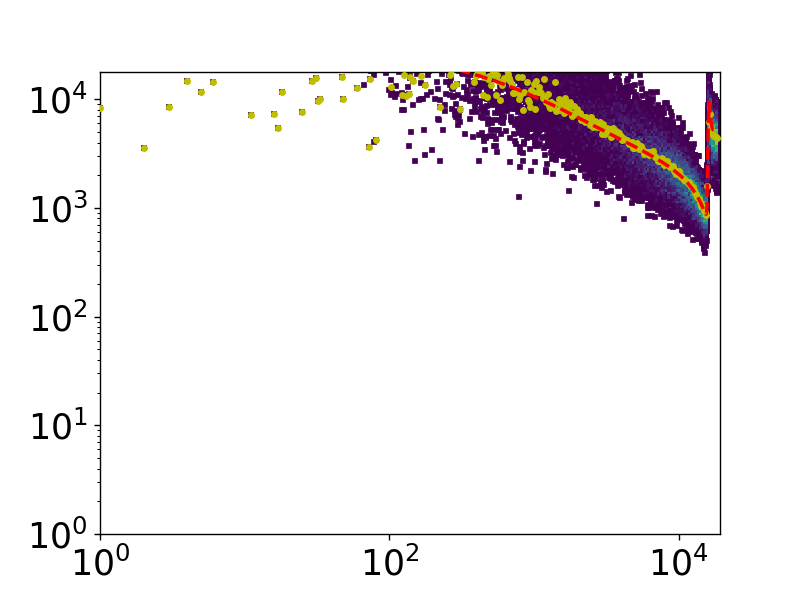

<IPython.core.display.Javascript object>


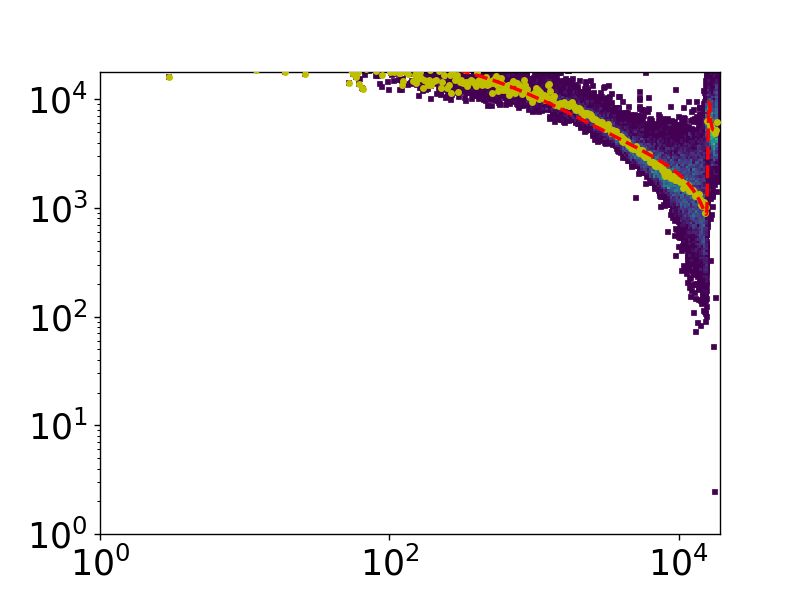

<IPython.core.display.Javascript object>


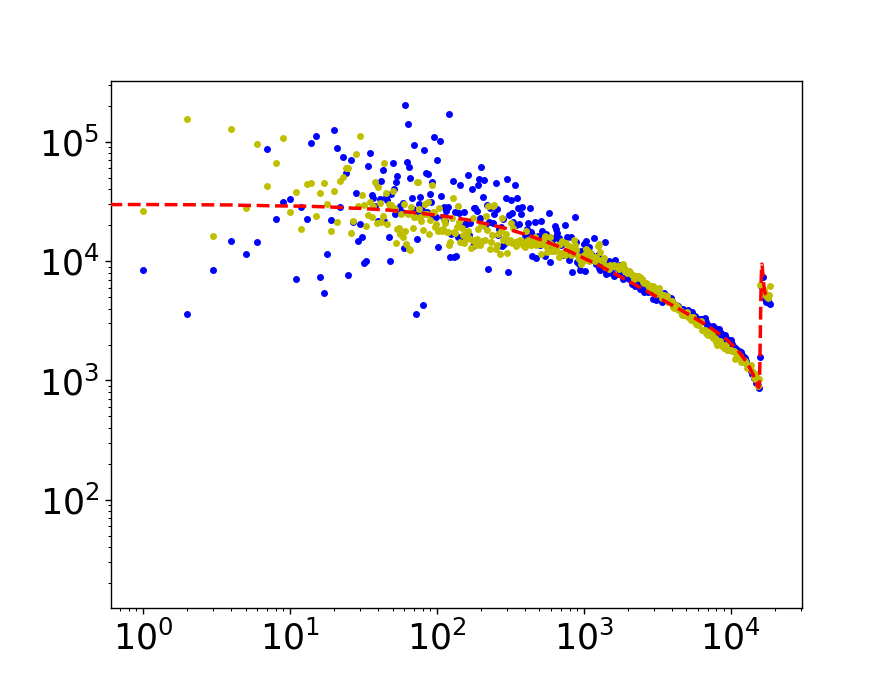

<ErrorbarContainer object of 3 artists>

In [97]:
plt.ion()
plt.figure()
#plt.loglog((PS_full_1))
#plt.loglog((PS_full_1+PS_full_2)/2)
#plt.loglog(10**(np.log10((PS_full_1+PS_full_2+PS_full_3)/3)*a_spatial+b_spatial))

#plt.loglog(10**(np.log10(PS_full)*a_spatial+b_spatial), zorder=0)
binned_SPS_sim = np.array([np.median(elem) for elem in np.array_split(10**(np.log10(PS_full)*a_spatial+b_spatial), bins)])
binned_SPS_points_sim = np.array([elem.mean() for elem in np.array_split(np.arange(18715), bins)])
binned_SPS_err_sim = np.array([sp.stats.sem(elem) for elem in np.array_split(10**(np.log10(PS_full)*a_spatial+b_spatial), bins)])
true_SPS=empirical_SPS
plt.loglog(np.arange(len(eigenvalues)),10**(np.log10(PS_full)*a_spatial+b_spatial), marker='s', linestyle='', markersize=2, zorder=1, color=[0.267004, 0.004874, 0.329415, 1.])
##sns.kdeplot(np.arange(first_k, last_k), true_SPS, vertical=True, n_levels=500, shade=True)
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
#plt.hist2d(np.arange(first_k, last_k), true_SPS, (plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
plt.hist2d(np.arange(len(eigenvalues)),10**(np.log10(PS_full)*a_spatial+b_spatial),(plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
plt.loglog(np.arange(len(eigenvalues)), 10**(np.log10(Gk)*a_spatial+b_spatial), zorder=4,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points_sim, y=binned_SPS_sim, yerr=0, zorder=3, fmt='yo',markersize=3)
true_SPS=np.log10(True_Spatial_Spectrum)

plt.figure()
#plt.loglog((PS_full_1))
#plt.loglog((PS_full_1+PS_full_2)/2)
#plt.loglog(10**(np.log10((PS_full_1+PS_full_2+PS_full_3)/3)*a_spatial+b_spatial))

#plt.loglog(10**(np.log10(PS_full)*a_spatial+b_spatial), zorder=0)
true_SPS=empirical_SPS
plt.loglog(np.arange(first_k, last_k), true_SPS, marker='s', linestyle='', markersize=2, zorder=1, color=[0.267004, 0.004874, 0.329415, 1.])
##sns.kdeplot(np.arange(first_k, last_k), true_SPS, vertical=True, n_levels=500, shade=True)
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
plt.hist2d(np.arange(first_k, last_k), true_SPS, (plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
#plt.hist2d(np.arange(len(eigenvalues)),10**(np.log10(PS_full)*a_spatial+b_spatial),(plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
plt.loglog(np.arange(len(eigenvalues)), 10**(np.log10(Gk)*a_spatial+b_spatial), zorder=4,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=0, zorder=3, fmt='yo',markersize=3)
true_SPS=np.log10(True_Spatial_Spectrum)

plt.figure()
plt.loglog(np.arange(len(eigenvalues)), 10**(np.log10(Gk)*a_spatial+b_spatial), zorder=4,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points_sim, y=binned_SPS_sim, yerr=0, fmt='bo',markersize=3)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=0, fmt='yo',markersize=3)

In [77]:
plt.close('all')

In [ ]:
##########################################################################################################
0.0001 10 slightly too high (time interval not small enough)
0.00008 8 slightly too high (time interval not small enough?)
0.00005 10 not doable
0.00005 7 slightly too low
0.00005 5 slightly too low (duration too short?)
0.00001 1 white noise like (low) (duration too short)

In [ ]:
#further verification: 1D grid simulation (linearized wilson-cowan: perturbation about steady state)

#duration and timestep
Time=3
Delta_t=0.00001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
syn=150
gridsize=1000
h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]   



Beta_E_total_1D = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
plt.close('all')
Max_omega=3000
Delta_omega=0.5

PS_full_1D, TPS_full_1D = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total_1D,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=True, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=None, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#MISC
#Beta_E_total=np.load('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy')
#del Beta_E_total
#del eigenvectors
#del connectome_activity
#np.save('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy', Beta_E_total)
#print(len(Beta_E_total[0]))
#print(Beta_E_total[0])
with h5py.File("G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.h5") as hf:
    if "Activity" not in list(hf.keys()):
        #connectome_activity=np.dot(eigenvectors,Beta_E_total)
        hf.create_dataset("Activity",  data=connectome_activity)
    else:
        print("Warning: overwriting results of a previous simulation.") 

In [ ]:
#################******** PROPAGATOR TESTS ********#################

In [ ]:
#propagator test 1
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1, h=1 (worked with 2-normalized eigenvalues)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.001
#nonzero c: switch from damped wave to telegrapher eqn
c=0

gridsize=1000
syn=0
h=1
u_0=0.3*sp.signal.gaussian(gridsize, 10)#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=100
#u_0[499]=1
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 2
gridsize=1000
syn=0
h=1
u_0=np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=Delta_t
u_0[499]=400
#u_0=np.ones(gridsize)
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Gaussian', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
np.sum(u_final)

In [ ]:
#proptest 3 cortical mesh convolutions

u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
u_0[6369]=50
u_prop=graph_propagator_test(u_0, Time=50, Delta_t=50, kernel_param=50/1000000, Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 4: cortical mesh
##NOTE: THESE PARAMETERS WERE FOR THE EIGENVALUES OF THE LAPLACIAN IN MILLIMIETERS
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.005
#nonzero c: switch from damped wave to telegrapher eqn
c=0

#in metres it should be enough to do (also change initial gaussian kernel param)
a*=1000000
b*=1000000


u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=10
u_0[6369]=50

#gauss kernel parm 50/1000000


u_1=graph_propagator_test(np.dot(eigenvectors.T,u_0), Time=2, Delta_t=1, kernel_param=1, 
                          Graph_Kernel='Pyramid', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=graph_propagator_test(u_1[:,1], Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                       
                          Visual=False, SaveActivity=True, Filepath=' ', NSim=0)
u_total=np.dot(eigenvectors,u_total)

In [ ]:
#propagator test 5 stochastic damped wave in fourier domain for quantitative spectrum calculation

#make a smaller: wave travels faster
#make b larger: more diffusion

#nonzero c: switch from damped wave to telegrapher eqn
c=0


a=0.3*1000000
b=0.05*1000000
sigma_noise=0.0001


beta_0=np.ones(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=200

dw_beta_act=graph_propagator_test(np.dot(eigenvectors.T, beta_0), Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c,
                                 sigma_noise=sigma_noise,
                                 one_dim=False, syn=0, gridsize=0,  h=0, GF_domain=True, eigvals=eigenvalues,                          
                                 Visual=False, SaveActivity=False, Filepath=' ', NSim=0)


#dw_PS_pred

In [ ]:
#dw_beta_act = np.load('G:\Macbook Stuff\Simulation Results\Damped Wave Kernel Test t=1\0# Sim Activity.h5')
dw_PS = np.var(dw_beta_act, axis=1)
dw_TPS = sp.signal.periodogram(dw_beta_act, fs=1/Delta_t, detrend='constant', scaling='density')
f = plt.figure()
plt.plot(dw_PS)
f2 = plt.figure()
plt.plot(dw_TPS[0]*(2*np.pi),np.sum(dw_TPS[1], axis=0))

In [ ]:
a=10000
b=50000000
sigma_noise=0.001

lambdas, omegas = np.meshgrid(eigenvalues, dw_TPS[0][1:]*(2*np.pi))
prediction = sigma_noise**2 / (b**2 * omegas**2 + (lambdas - a*omegas**2)**2)

#f3 = plt.figure()
#ax = f3.add_subplot(111)
#pc = ax.pcolormesh(lambdas, omegas, prediction)
#f3.colorbar(pc)

f4 = plt.figure()
plt.plot(dw_TPS[0][1]*np.sum(prediction, axis=0)/np.pi)
f5 = plt.figure()
plt.plot(dw_TPS[0][1:]*(2*np.pi), 2*np.sum(prediction, axis=1))


In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])
AllVet=AllVet[:,indices]

dist=np.sqrt(AllVet[0,:]**2 + AllVet[1,:]**2 + AllVet[2,:]**2)
trace4 = go.Scatter3d(
    x=AllVet[0,:],
    y=AllVet[1,:],
    z=AllVet[2,:],
    #alphahull=50
    mode='markers',
    marker=dict(
        size=5,
        color=dist,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        #line=dict(color='rgba(0, 0, 0,0.5)',width=1,)
        )
    )
data = [trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
with h5py.File('G:/Macbook Stuff/Simulation Results/Damped Wave Kernel Test t=1/0# Sim Activity b=0.005.h5', 'r') as file:
    print(list(file.keys()))
    DWave = np.asarray(file['Activity'], dtype=float)

DWave[:,0]

In [ ]:
#beta_u_total=np.load('G:/Macbook Stuff/Simulation Results/new realistic activity.npy')#np.dot(eigenvectors, dw_beta_act)
#u_total=np.dot(eigenvectors,beta_u_total)
#del beta_u_total
#del eigenvectors
#covariance = np.cov(u_total)
#del u_total
#FC=np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5))))    
#del covariance

plt.close('all')
fig=plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(FC, vmax=0.1, vmin=-0.1)
fig.colorbar(im)

In [ ]:
Func_Conn_prediction = Functional_Connectivity(eigenvectors, Spectrum_spatial_only[:,0,0], one_dim=False, Visual=True)

In [ ]:
#np.save('G:/Macbook Stuff/Simulation Results/FC new realistic', FC)
#np.save('G:/Macbook Stuff/Simulation Results/new realistic activity', u_total)

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

#mesh (or full connectome) graph edges
#trace1=Scatter3d(x=Xe,
#               y=Ye,
#               z=Ze,
#               mode='lines',
#              line=Line(color='rgba(0,0,0,1)', width=1),
#             )

#Mesh3d
trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
           #dont use this line   intensity=DWave[:,0],
             lighting = dict(ambient=1, diffuse=0.1, roughness = 0.9, specular=1.8, fresnel=0.01)#,
              #colorlimits USE IF NEEDED
              #cmin=-10E-9,#-0.1,#-10E-9,#-0.1,
              #cmax=10E-9#0.1#10E-9#0.1
              #eigenvectors[:,1001]#
              
            
              
          #     mode='markers',
          #  marker=dict(
          #          size=5,
          #          color=-AllVet[1,:],#np.sqrt(AllVet[2,:]**2+AllVet[0,:]**2+AllVet[1,:]**2),                # set color to an array/list of desired values
          #          colorscale='Viridis',   # choose a colorscale
          #          opacity=0.8,
          #          line=dict(color='rgba(0, 0, 0,0.5)',
          #                     width=1,
        #                     )
        #                )
                )


###SET WHAT IS GONNA BE PLOTTED
interval = 1
start_time = 18500
max_time = 18510#11* interval

frames =[dict(data=[dict(type='mesh3d', 
                         #HERE IS WHAT DECIDES THE COLOR-TIMEPLOT
                         intensity=eigenvectors[:,i])],#u_total[:,i])],
                  traces=[0],
                  name='{}'.format(i)) for i in range(start_time,max_time,interval)] 






axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),  
    hovermode=False,     autosize=False,
    width=1000,
    height=1150
)       
data=[trace2]

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 120, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]



fig_frames['layout']['sliders'] = [{
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'time=',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 120, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 5},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [{
    'method': 'animate',
    'label': '{}'.format(i),
   # 'value': '',
    'args': [[i], {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate'}
    ],
} for i in range(start_time,max_time,interval)]
}]



#fig=Figure(data=data, layout=layout)

offline.iplot(fig_frames, filename='Les-Miserables')

In [ ]:
with h5py.File('G:/Macbook Stuff/Downloads/Fibers.mat', 'r') as file:
    print(list(file.keys()))
    print(list(file['fgCC'].keys()))
        
    Fibers=[file[element][:] for element in file['fgCC']['fibers'][0]]

fiber_edges=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy')
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
f.close()
indices = np.array([elem[0] for elem in CC])-1
EX=[]
EY=[]
EZ=[]
colors=[]

counter=0
for i in range(0,len(Fibers),2):
    if fiber_edges[i,0] in indices and fiber_edges[i,1] in indices and fiber_edges[i,0]!=fiber_edges[i,1]:
        counter+=1
        for j in range(Fibers[i].shape[0]-1):
            EX+=[Fibers[i][j,0], Fibers[i][j+1,0], None]
            EY+=[Fibers[i][j,1], Fibers[i][j+1,1], None]
            EZ+=[Fibers[i][j,2], Fibers[i][j+1,2], None]

counter    


    

In [ ]:
fig_frames.write_image("G:/fig1.png")

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

trace3=Scatter3d(x=EX,
               y=EY,
               z=EZ,
               mode='lines',
               line=Line(color=EX,#'rgba(100,100,100,0.9)',#colors
                         #colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']],#'Rainbow',
                         width=1),
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False
)       
data=Data([trace3])
fig=Figure(data=data, layout=layout)

offline.iplot(fig, filename='Les-Miserables-2')